# Laboratory 5

## Variant 5

# Introduction

This lab involves building a multilayer perceptron that will classify images from the KMNIST dataset. The neural network will be trained using mini-batch gradient descent and the main idea of this experiment is to explore the effect of different choices of hyper-parameters and components. For each experiment, the following will be provided:
* The loss value for every learning step (which represents the sum of errors).
* The accuracy on the training and validation set after each epoch.

The library that will be used is TensorFlow and will make use of its Keras API to create the multi-layer perceptron. With that being said, let's get to it.

# Exploring The Data

We will begin by importing the necessary libraries.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

2024-05-08 01:59:03.384157: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 01:59:03.384189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 01:59:03.385243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 01:59:03.390829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/torx/anaconda3/envs/EARIN/lib

Let's now import the data set and take a look at what we are working with:

In [3]:
ds, info = tfds.load("KMNIST", split='train+test', with_info=True, as_supervised=True)
info

2024-05-08 01:59:55.499064: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-08 01:59:55.499085: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:236] Using CUDA malloc Async allocator for GPU: 0
2024-05-08 01:59:55.499412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14320 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:07:00.0, compute capability: 8.9
2024-05-08 01:59:55.499655: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-08 01:59:55.499665: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:236] Using CUDA malloc Async allocator for GPU: 1
2024-05-08 01:59:55.4999

tfds.core.DatasetInfo(
    name='kmnist',
    full_name='kmnist/3.0.1',
    description="""
    Kuzushiji-MNIST is a drop-in replacement for the MNIST dataset (28x28 grayscale, 70,000 images), provided in the original MNIST format as well as a NumPy format. Since MNIST restricts us to 10 classes, we chose one character to represent each of the 10 rows of Hiragana when creating Kuzushiji-MNIST.
    """,
    homepage='http://codh.rois.ac.jp/kmnist/index.html.en',
    data_dir='/home/torx/tensorflow_datasets/kmnist/3.0.1',
    file_format=tfrecord,
    download_size=20.26 MiB,
    dataset_size=31.76 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@

While the tfds.load method does allow us to immediately get the testing and training sets, it makes sense to first look at the complete training set in order to explore how the data is distributed, to do so, we will convert the dataset into a Pandas DataFrame, and then check the distribution of the label column to determine if the dataset is equally distributed.

In [4]:
data = tfds.as_dataframe(ds, info)
data.info()
labels = data['label'].to_frame()

<class 'tensorflow_datasets.core.as_dataframe.as_dataframe.<locals>.StyledDataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   70000 non-null  object
 1   label   70000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
labels.value_counts() / len(labels)

label
0        0.1
1        0.1
2        0.1
3        0.1
4        0.1
5        0.1
6        0.1
7        0.1
8        0.1
9        0.1
Name: count, dtype: float64

We see that the data is indeed equally distributed, so there's not much to be done to it in terms of how we should split the training and test set. Thus, we will use tfds.load's splitting in order to have a training and testing set.

In [6]:
ds_train, train_info = tfds.load("kmnist", split="train", with_info=True, as_supervised=True, batch_size=-1)

In [7]:
train_info

tfds.core.DatasetInfo(
    name='kmnist',
    full_name='kmnist/3.0.1',
    description="""
    Kuzushiji-MNIST is a drop-in replacement for the MNIST dataset (28x28 grayscale, 70,000 images), provided in the original MNIST format as well as a NumPy format. Since MNIST restricts us to 10 classes, we chose one character to represent each of the 10 rows of Hiragana when creating Kuzushiji-MNIST.
    """,
    homepage='http://codh.rois.ac.jp/kmnist/index.html.en',
    data_dir='/home/torx/tensorflow_datasets/kmnist/3.0.1',
    file_format=tfrecord,
    download_size=20.26 MiB,
    dataset_size=31.76 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@

We can see here that our dataset constists of the image itself, and its corresponding label. We can also see that our image consists of the uint8 datatype, which an 8 bit unsigned integer, we can in fact view what the image looks like, for example, if we consider a single instance:

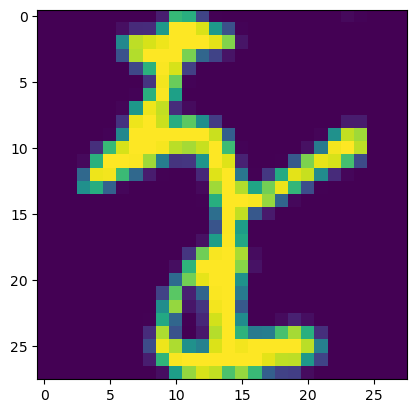

In [8]:
import matplotlib.pyplot as plt
img = ds.take(1)
for example in img:
    plt.imshow(example[0])
    

With the current dataset we have, there are two things to be done to each image:
* Scale the pixel values to a floating point number between 0 and 1, rather than 0 and 255, which is what an 8 bit pixel takes one
* "flaten" the image, which means that rather than each image being represented as a 28x28 grid, it will now be represented by a series of numbers, 28x28=784 to be exact, each corresponding to a pixel.

The scaling is necessary as neural networks tend to work best with values between 0 and 1. This practically turns the image into gray-scale, with 0 being black, and 1 being white:

In [9]:
X = ds_train[0]
y = ds_train[1]

Then, we convert them to a numpy array

In [10]:
X = X.numpy()
y = y.numpy()

In [11]:
X_train_full = X[:, :, :, 0]

Now, we will normalize and splite the training set into a train and validation set:

In [12]:
split_idx = int(len(X_train_full) * 0.2)
X_valid, X_train = X_train_full[:split_idx] / 255.0, X_train_full[split_idx:] / 255.0
y_valid, y_train = y[:split_idx], y[split_idx:]

Let's take a look at how our image looks now:

In [13]:
X_valid.max()

1.0

Max value is 1, this confirms that it has been normalized.

# Getting a Model Up and Running

With our data normalized, we can now move on to creating the multi-layer perceptron. For this, we will use the Sequential Keras API to create a multi-layer perceptron with an input layer, a hidden layer, and an output layer. The number of neurons in the input layer will essentially be the same as the flattened image, i.e. 28x28=784. The number of output neurons in the output layer will be 10, one for each label. As for the number of neurons in the hidden layer, and in fact, how many hidden layers there will be, this is something we will experiment with, but for starters, we will have 300 neurons per hidden layer.

Regarding the activation functions, since our classficiation classes are mutually exclusive, we will use softmax regression for our output layer, as for the hidden layer, we will use the rectified linear unit (ReLU) activation function.

In [14]:
keras.utils.set_random_seed(42)
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))


Let's take a look at an overview of our model:

In [53]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 784)               0         
                                                                 
 dense_144 (Dense)           (None, 300)               235500    
                                                                 
 dense_145 (Dense)           (None, 10)                3010      
                                                                 
Total params: 238510 (931.68 KB)
Trainable params: 238510 (931.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can also take a look at how our model looks like:

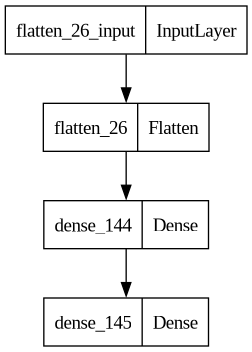

In [54]:
keras.utils.plot_model(model)

The models weights are randomly initialized, which is good as we would like to break symmetry, we can take a look at them via:

In [55]:
initial_weights = model.get_weights()

We now move on to compiling and training the model, when compiling, we can specify its some parameters, which are the loss function, training method, and what metric is used for evaluating the model. which is as follows:

In [56]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])

Now we can move on to training our model, and for this we will use the following parameters:
* $\text{epochs} = 30$
* $\text{mini-batch size} = 30$ (the default)

and take a look at its graph.

In [57]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.9247 - accuracy: 0.7418 - val_loss: 0.6216 - val_accuracy: 0.8218
Epoch 2/30
  56/1500 [>.............................] - ETA: 1s - loss: 0.6099 - accuracy: 0.8225

1500/1500 [==============================] - 2s 1ms/step - loss: 0.5410 - accuracy: 0.8441 - val_loss: 0.5051 - val_accuracy: 0.8523
Epoch 3/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4545 - accuracy: 0.8673 - val_loss: 0.4413 - val_accuracy: 0.8698
Epoch 4/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4004 - accuracy: 0.8837 - val_loss: 0.4024 - val_accuracy: 0.8808
Epoch 5/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3610 - accuracy: 0.8968 - val_loss: 0.3695 - val_accuracy: 0.8917
Epoch 6/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3298 - accuracy: 0.9057 - val_loss: 0.3440 - val_accuracy: 0.8991
Epoch 7/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3040 - accuracy: 0.9136 - val_loss: 0.3214 - val_accuracy: 0.9071
Epoch 8/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2827 - accuracy: 0.9206 - val_loss: 0.3038 - val_accuracy: 0.9119
Epo

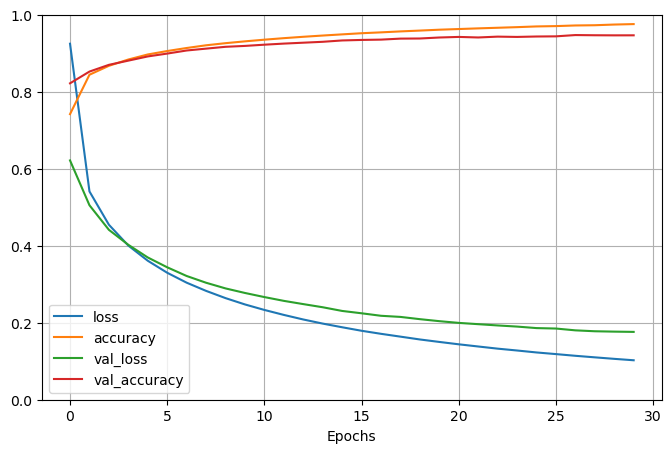

In [58]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epochs")
plt.show()

The history variable will allow us to access different attributes of the model, let's see what the best accuracy was:

In [59]:
accuracies = history.history['val_accuracy']
best_acc = max(accuracies)
idx = accuracies.index(best_acc)
print(f"Best Accuracy: {best_acc} At Index: {idx}")

Best Accuracy: 0.9471666812896729 At Index: 26


We see here that in-fact, the best validation accuracy was achieved on the second to last epoch, it is a good idea to run this for a higher epoch value, just to make sure that we are achieving the best possible validation accuracy.

Epoch 1/60
 265/1500 [====>.........................] - ETA: 1s - loss: 1.6335 - accuracy: 0.5307

1500/1500 [==============================] - 2s 1ms/step - loss: 0.9247 - accuracy: 0.7418 - val_loss: 0.6216 - val_accuracy: 0.8218
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5410 - accuracy: 0.8441 - val_loss: 0.5051 - val_accuracy: 0.8523
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4545 - accuracy: 0.8673 - val_loss: 0.4413 - val_accuracy: 0.8699
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4004 - accuracy: 0.8838 - val_loss: 0.4024 - val_accuracy: 0.8809
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3610 - accuracy: 0.8968 - val_loss: 0.3695 - val_accuracy: 0.8915
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3298 - accuracy: 0.9057 - val_loss: 0.3440 - val_accuracy: 0.8990
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3040 - accuracy: 0.9136 - val_loss: 0.3214 - val_accuracy: 0.9074
Epo

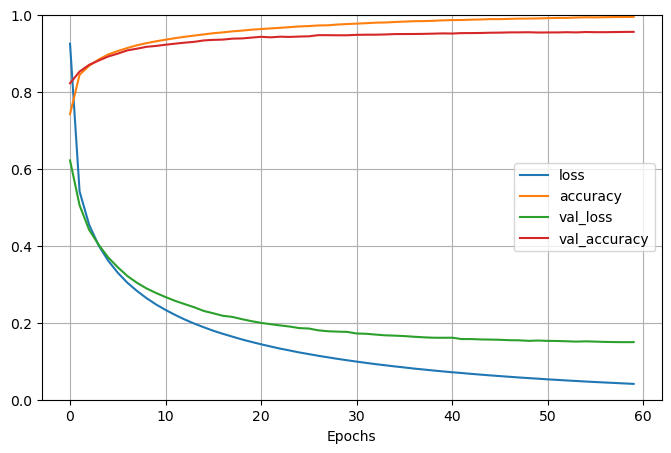

Best Accuracy: 0.9555000066757202 At Index: 59


In [60]:
model.reset_metrics()
model.set_weights(initial_weights)
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epochs")
plt.show()
accuracies = history.history['val_accuracy']
best_acc = max(accuracies)
idx = accuracies.index(best_acc)
print(f"Best Accuracy: {best_acc} At Index: {idx}")

Once again, it seems like we reached the best accuracy towards the end of our epoch count, does this mean we will have to keep on increasing the number of epochs? Well, that would be computationally expensive, as the more epochs a model has to train for, the more time it requires, with more complex models models, (with more hidden layers for example), then the time would increase exponentially. Yet the question remains, how do we determine when the model is performing well enough? If we take a look at how the result was when we only ran it for 30 epochs, the best validation accuracy was approximately 0.95, so there is only an improvement of 0.005, which is rather negligble, so what if we were able to stop the training process earlier, once we had reached a point where the model isn't improving by much? This is where early-stopping can be used.

Early-stopping is a technique that does just that, stop the training process earlier on once a satisfying criteria has been reached. For example, we may want to stop training once the validation loss stops decreasing.

Epoch 1/60
  54/1500 [>.............................] - ETA: 1s - loss: 2.1789 - accuracy: 0.2060

1500/1500 [==============================] - 2s 1ms/step - loss: 0.9247 - accuracy: 0.7418 - val_loss: 0.6216 - val_accuracy: 0.8218
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5410 - accuracy: 0.8442 - val_loss: 0.5051 - val_accuracy: 0.8524
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4545 - accuracy: 0.8673 - val_loss: 0.4413 - val_accuracy: 0.8700
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4004 - accuracy: 0.8837 - val_loss: 0.4024 - val_accuracy: 0.8813
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3610 - accuracy: 0.8968 - val_loss: 0.3695 - val_accuracy: 0.8914
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3298 - accuracy: 0.9058 - val_loss: 0.3440 - val_accuracy: 0.8992
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3040 - accuracy: 0.9135 - val_loss: 0.3214 - val_accuracy: 0.9073
Epo

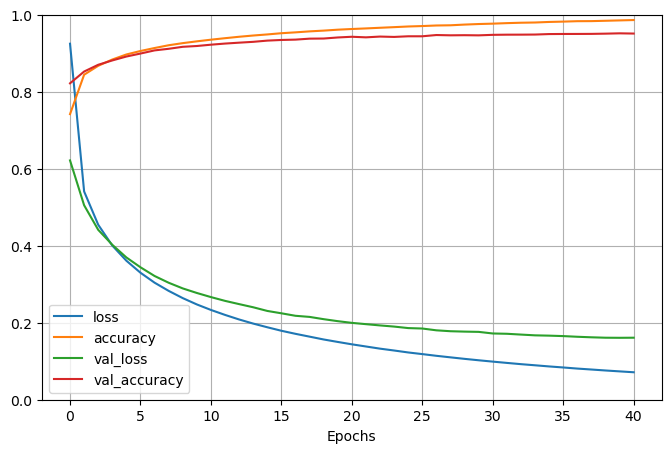

Best Accuracy: 0.9516666531562805 At Index: 39


In [61]:
callback = keras.callbacks.EarlyStopping()
model.reset_metrics()
model.set_weights(initial_weights)
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_valid, y_valid), callbacks=[callback])
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epochs")
plt.show()
accuracies = history.history['val_accuracy']
best_acc = max(accuracies)
idx = accuracies.index(best_acc)
print(f"Best Accuracy: {best_acc} At Index: {idx}")

Despite having defined 60 as the number of epochs, we were able to achieve a good result at the 40th epoch, this is because the Early Stopping method automatically defaults tracking the validation loss, if it stops decreasing, then it stops training, as we have reached a hypothetical upper bound. This saved us from training for an extra 20 epochs!

# Parameter Fine-Tuning

Now let's start by tuning the hyper-parameters, the goal here is to reach a point where validation loss stops decreasing in the lowest number of epochs. These are parameters we are interested in tuning:
* Number of Hidden Layers
* Number of Neurons in the Hidden Layers
* Learning Rate
* Optimizer
* Mini-Batch Size

We will start with higher level parameters (not sure if this is the right term, I consider the network's structure to be a higher level than something like learning rate, because learning rate is applied to the network itself) such as the number of hidden layers and number of neurons per hidden layer.

According to (<a href="https://arxiv.org/abs/1206.5533">Yoshua Bengio, 2012</a>) it is good to keep the number of hidden neurons the same across the hidden layers, so we will follow that.

## Number of Hidden Layers

Let's start by exploring what happens if we have no hidden layers.

Epoch 1/60


1500/1500 [==============================] - 2s 985us/step - loss: 1.0786 - accuracy: 0.6990 - val_loss: 0.8324 - val_accuracy: 0.7596
Epoch 2/60
1500/1500 [==============================] - 1s 909us/step - loss: 0.7562 - accuracy: 0.7837 - val_loss: 0.7383 - val_accuracy: 0.7828
Epoch 3/60
1500/1500 [==============================] - 1s 909us/step - loss: 0.6949 - accuracy: 0.7985 - val_loss: 0.6998 - val_accuracy: 0.7936
Epoch 4/60
1500/1500 [==============================] - 1s 924us/step - loss: 0.6649 - accuracy: 0.8063 - val_loss: 0.6787 - val_accuracy: 0.8000
Epoch 5/60
1500/1500 [==============================] - 1s 908us/step - loss: 0.6462 - accuracy: 0.8112 - val_loss: 0.6653 - val_accuracy: 0.8037
Epoch 6/60
1500/1500 [==============================] - 1s 908us/step - loss: 0.6330 - accuracy: 0.8148 - val_loss: 0.6546 - val_accuracy: 0.8069
Epoch 7/60
1500/1500 [==============================] - 1s 901us/step - loss: 0.6231 - accuracy: 0.8169 - val_loss: 0.6467 - val_accura

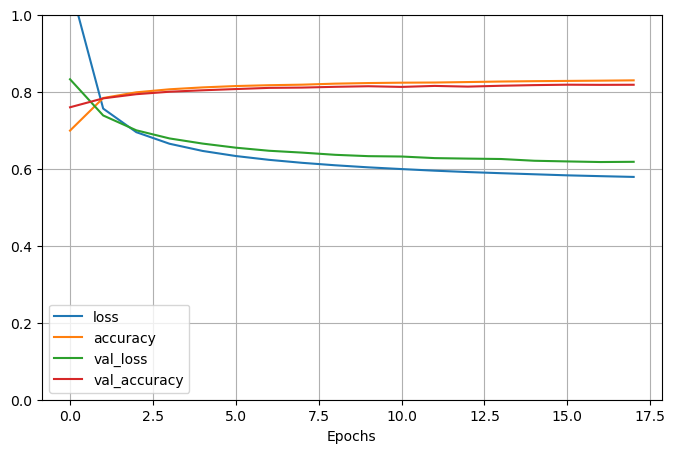

Best Accuracy: 0.8182500004768372 At Index: 15


In [62]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])
callback = keras.callbacks.EarlyStopping()
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_valid, y_valid), callbacks=[callback])
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epochs")
plt.show()
accuracies = history.history['val_accuracy']
best_acc = max(accuracies)
idx = accuracies.index(best_acc)
print(f"Best Accuracy: {best_acc} At Index: {idx}")

Within 15 epochs we have already reached close to our upper bound! Our validation loss stopped decreasing, and the accuracy achieved is approximately 0.82, much worse than previous results with one hidden layer and 300 neurons per hidden layer. 

Let's take a look at how our model would perform if we had 2 hidden layers, each with 300 neurons.

Epoch 1/60


1500/1500 [==============================] - 2s 1ms/step - loss: 0.9261 - accuracy: 0.7374 - val_loss: 0.5661 - val_accuracy: 0.8331
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4817 - accuracy: 0.8569 - val_loss: 0.4382 - val_accuracy: 0.8667
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3868 - accuracy: 0.8851 - val_loss: 0.3722 - val_accuracy: 0.8880
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3297 - accuracy: 0.9020 - val_loss: 0.3424 - val_accuracy: 0.8959
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2895 - accuracy: 0.9158 - val_loss: 0.3006 - val_accuracy: 0.9097
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2571 - accuracy: 0.9243 - val_loss: 0.2791 - val_accuracy: 0.9159
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2303 - accuracy: 0.9336 - val_loss: 0.2566 - val_accuracy: 0.9233
Epo

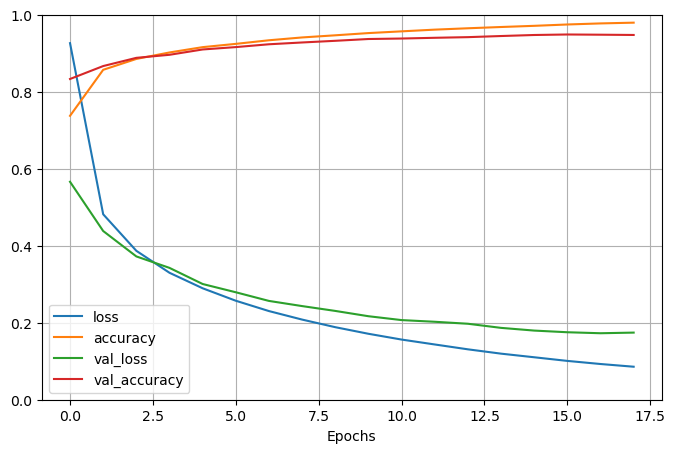

Best Accuracy: 0.9486666917800903 At Index: 15


In [63]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])
callback = keras.callbacks.EarlyStopping()
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_valid, y_valid), callbacks=[callback])
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epochs")
plt.show()
accuracies = history.history['val_accuracy']
best_acc = max(accuracies)
idx = accuracies.index(best_acc)
print(f"Best Accuracy: {best_acc} At Index: {idx}")

With two hidden layers, we achieved an accuracy that is comparable to one hidden layer, but it only took 15 epochs! What happens if we add yet another layer? Let's see what happens with 3 hidden layers:

Epoch 1/60
1500/1500 [==============================] - 3s 1ms/step - loss: 0.9133 - accuracy: 0.7418 - val_loss: 0.5422 - val_accuracy: 0.8375
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4542 - accuracy: 0.8640 - val_loss: 0.4045 - val_accuracy: 0.8802
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3543 - accuracy: 0.8942 - val_loss: 0.3313 - val_accuracy: 0.9003
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2933 - accuracy: 0.9130 - val_loss: 0.3112 - val_accuracy: 0.9061
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2506 - accuracy: 0.9262 - val_loss: 0.2632 - val_accuracy: 0.9216
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2153 - accuracy: 0.9368 - val_loss: 0.2468 - val_accuracy: 0.9247
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1871 - accuracy: 0.9469 - val_loss: 0.2230 - val_accuracy:

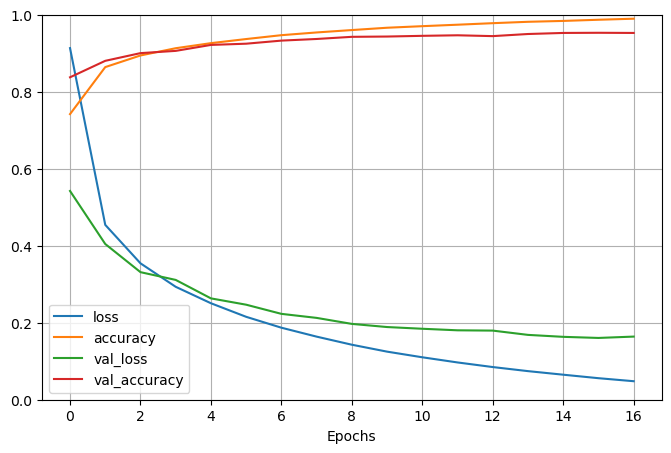

Best Accuracy: 0.953083336353302 At Index: 15


In [64]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])
callback = keras.callbacks.EarlyStopping()
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_valid, y_valid), callbacks=[callback])
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epochs")
plt.show()
accuracies = history.history['val_accuracy']
best_acc = max(accuracies)
idx = accuracies.index(best_acc)
print(f"Best Accuracy: {best_acc} At Index: {idx}")

To do some further exploring, let's define a function that will expedite getting a model up and running with different parameters, the function definition is as follows:

In [2]:
def MLP(hidden_layers: int, activation: str, n_hidden: int, optimizer: str, learning_rate=0.01, momentum=0.0, epochs=60, miniBatch=32, callBack=True, patience=0, monitor="val_loss"):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    for i in range(hidden_layers):
        model.add(keras.layers.Dense(n_hidden, activation=activation))
    model.add(keras.layers.Dense(10, activation="softmax"))
    if optimizer == "SGD":
        model.compile(loss="sparse_categorical_crossentropy",
                    optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
                    metrics=["accuracy"])
    else:
        model.compile(loss="sparse_categorical_crossentropy",
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=["accuracy"])
    if callBack is True:
        callback = keras.callbacks.EarlyStopping(monitor=monitor, patience=patience)
        history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), batch_size=miniBatch, callbacks=[callback])
    else:
        history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), batch_size=miniBatch)
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.gca().set_xlabel("Epochs")
    plt.show()
    accuracies = history.history['val_accuracy']
    best_acc = max(accuracies)
    idx = accuracies.index(best_acc)
    print(f"Best Accuracy: {best_acc} At Index: {idx}")
    return history

Let's now create two plots, Validation Accuracy vs. Number of Hidden Layers, and number of epochs it took to reach a non-decreasing validation loss.

Epoch 1/60


1500/1500 [==============================] - 2s 1ms/step - loss: 0.9238 - accuracy: 0.7408 - val_loss: 0.6362 - val_accuracy: 0.8151
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5547 - accuracy: 0.8407 - val_loss: 0.5171 - val_accuracy: 0.8496
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4635 - accuracy: 0.8654 - val_loss: 0.4497 - val_accuracy: 0.8695
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4064 - accuracy: 0.8824 - val_loss: 0.4096 - val_accuracy: 0.8806
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3657 - accuracy: 0.8940 - val_loss: 0.3773 - val_accuracy: 0.8898
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3342 - accuracy: 0.9036 - val_loss: 0.3501 - val_accuracy: 0.8978
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3084 - accuracy: 0.9116 - val_loss: 0.3286 - val_accuracy: 0.9040
Epo

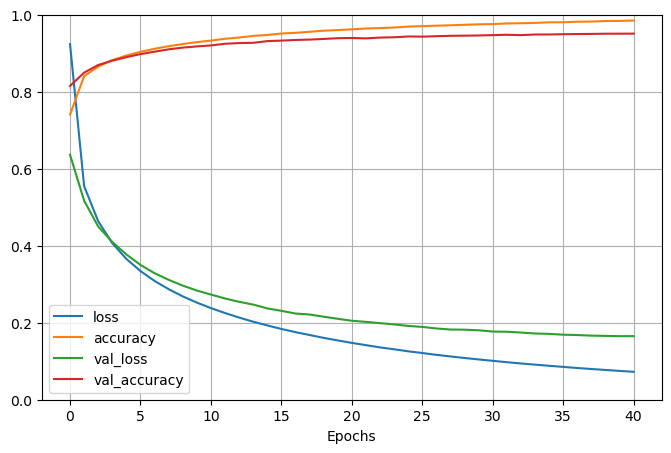

Best Accuracy: 0.9509166479110718 At Index: 40
Epoch 1/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.9026 - accuracy: 0.7481 - val_loss: 0.5662 - val_accuracy: 0.8342
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4839 - accuracy: 0.8565 - val_loss: 0.4428 - val_accuracy: 0.8694
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3905 - accuracy: 0.8845 - val_loss: 0.3762 - val_accuracy: 0.8885
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3331 - accuracy: 0.9026 - val_loss: 0.3477 - val_accuracy: 0.8961
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2925 - accuracy: 0.9147 - val_loss: 0.3068 - val_accuracy: 0.9083
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2594 - accuracy: 0.9245 - val_loss: 0.2823 - val_accuracy: 0.9169
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2320 - accu

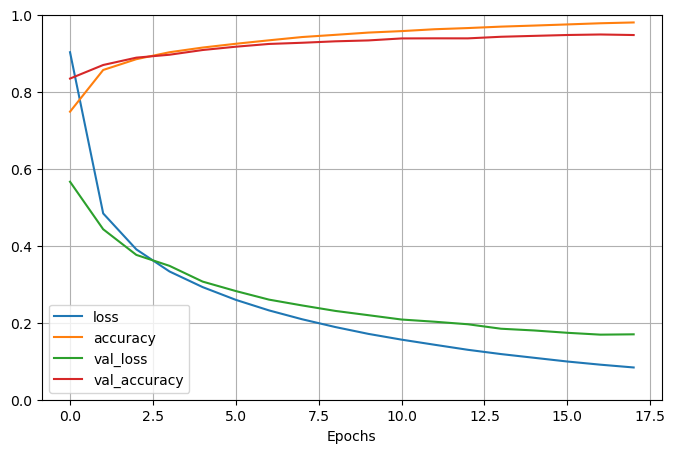

Best Accuracy: 0.9486666917800903 At Index: 16
Epoch 1/60
1500/1500 [==============================] - 3s 1ms/step - loss: 0.9244 - accuracy: 0.7351 - val_loss: 0.5452 - val_accuracy: 0.8354
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4523 - accuracy: 0.8639 - val_loss: 0.4058 - val_accuracy: 0.8775
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3521 - accuracy: 0.8950 - val_loss: 0.3360 - val_accuracy: 0.8995
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2901 - accuracy: 0.9140 - val_loss: 0.3086 - val_accuracy: 0.9069
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2463 - accuracy: 0.9271 - val_loss: 0.2665 - val_accuracy: 0.9210
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2107 - accuracy: 0.9386 - val_loss: 0.2487 - val_accuracy: 0.9252
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1821 - accu

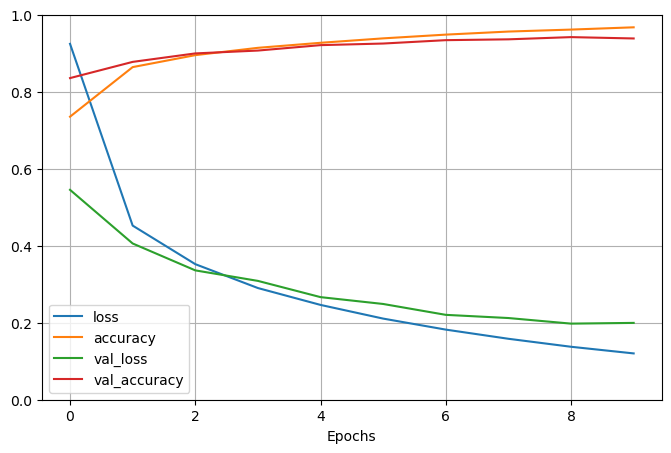

Best Accuracy: 0.9418333172798157 At Index: 8
Epoch 1/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.9443 - accuracy: 0.7250 - val_loss: 0.5212 - val_accuracy: 0.8420
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4247 - accuracy: 0.8714 - val_loss: 0.3749 - val_accuracy: 0.8861
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3208 - accuracy: 0.9044 - val_loss: 0.3040 - val_accuracy: 0.9080
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2564 - accuracy: 0.9240 - val_loss: 0.2909 - val_accuracy: 0.9127
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2123 - accuracy: 0.9377 - val_loss: 0.2497 - val_accuracy: 0.9247
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1769 - accuracy: 0.9488 - val_loss: 0.2351 - val_accuracy: 0.9295
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1489 - accur

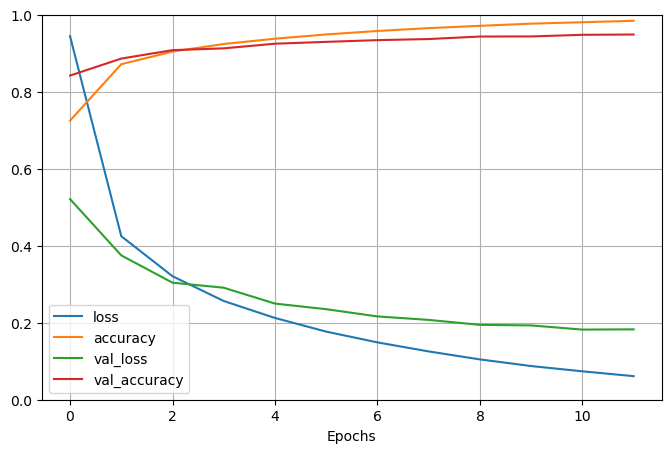

Best Accuracy: 0.9485833048820496 At Index: 11
Epoch 1/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.9767 - accuracy: 0.7152 - val_loss: 0.5219 - val_accuracy: 0.8409
Epoch 2/60
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4206 - accuracy: 0.8720 - val_loss: 0.3555 - val_accuracy: 0.8919
Epoch 3/60
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3112 - accuracy: 0.9076 - val_loss: 0.2892 - val_accuracy: 0.9144
Epoch 4/60
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2454 - accuracy: 0.9274 - val_loss: 0.2715 - val_accuracy: 0.9173
Epoch 5/60
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2002 - accuracy: 0.9405 - val_loss: 0.2370 - val_accuracy: 0.9277
Epoch 6/60
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1631 - accuracy: 0.9520 - val_loss: 0.2145 - val_accuracy: 0.9350
Epoch 7/60
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1338 - accu

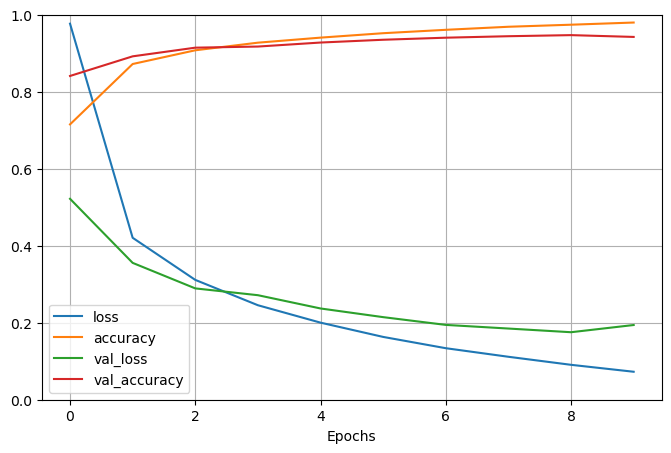

Best Accuracy: 0.9470000267028809 At Index: 8
Epoch 1/60
1500/1500 [==============================] - 3s 2ms/step - loss: 1.0810 - accuracy: 0.6719 - val_loss: 0.5488 - val_accuracy: 0.8328
Epoch 2/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4169 - accuracy: 0.8721 - val_loss: 0.3487 - val_accuracy: 0.8925
Epoch 3/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2947 - accuracy: 0.9109 - val_loss: 0.2776 - val_accuracy: 0.9142
Epoch 4/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2245 - accuracy: 0.9334 - val_loss: 0.2629 - val_accuracy: 0.9204
Epoch 5/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1772 - accuracy: 0.9473 - val_loss: 0.2127 - val_accuracy: 0.9352
Epoch 6/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1408 - accuracy: 0.9587 - val_loss: 0.2018 - val_accuracy: 0.9392
Epoch 7/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1115 - accur

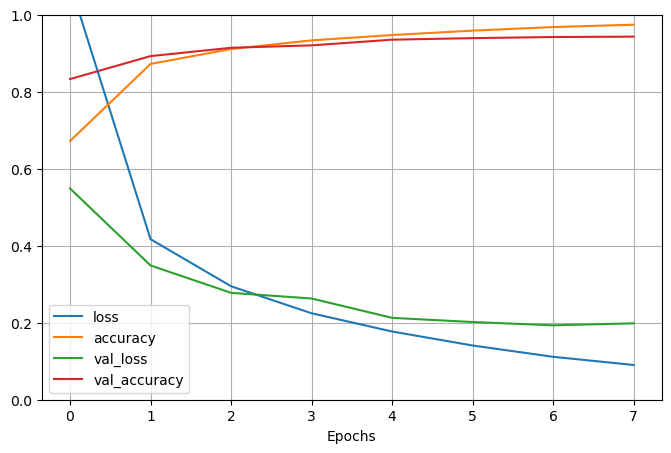

Best Accuracy: 0.9430833458900452 At Index: 7
Epoch 1/60
1500/1500 [==============================] - 4s 2ms/step - loss: 1.1831 - accuracy: 0.6278 - val_loss: 0.5615 - val_accuracy: 0.8247
Epoch 2/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4231 - accuracy: 0.8702 - val_loss: 0.3465 - val_accuracy: 0.8935
Epoch 3/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2903 - accuracy: 0.9121 - val_loss: 0.2666 - val_accuracy: 0.9157
Epoch 4/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2195 - accuracy: 0.9341 - val_loss: 0.2638 - val_accuracy: 0.9192
Epoch 5/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1737 - accuracy: 0.9477 - val_loss: 0.2425 - val_accuracy: 0.9260
Epoch 6/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1370 - accuracy: 0.9596 - val_loss: 0.2202 - val_accuracy: 0.9320
Epoch 7/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1083 - accur

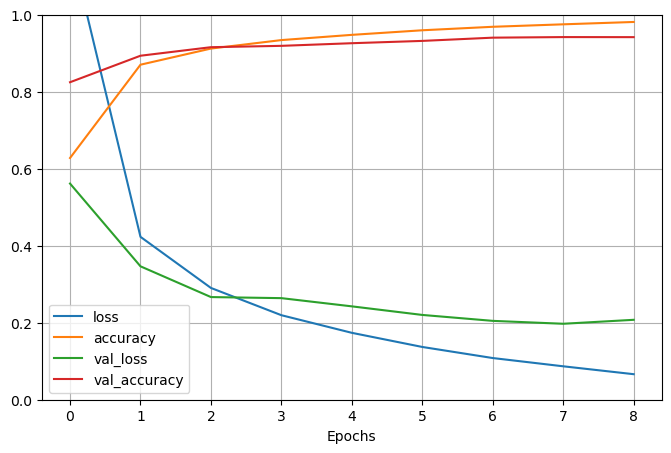

Best Accuracy: 0.9419166445732117 At Index: 7
Epoch 1/60
1500/1500 [==============================] - 4s 2ms/step - loss: 1.2771 - accuracy: 0.5902 - val_loss: 0.6052 - val_accuracy: 0.8137
Epoch 2/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4389 - accuracy: 0.8642 - val_loss: 0.3392 - val_accuracy: 0.8969
Epoch 3/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2911 - accuracy: 0.9113 - val_loss: 0.2658 - val_accuracy: 0.9204
Epoch 4/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2160 - accuracy: 0.9368 - val_loss: 0.2743 - val_accuracy: 0.9163


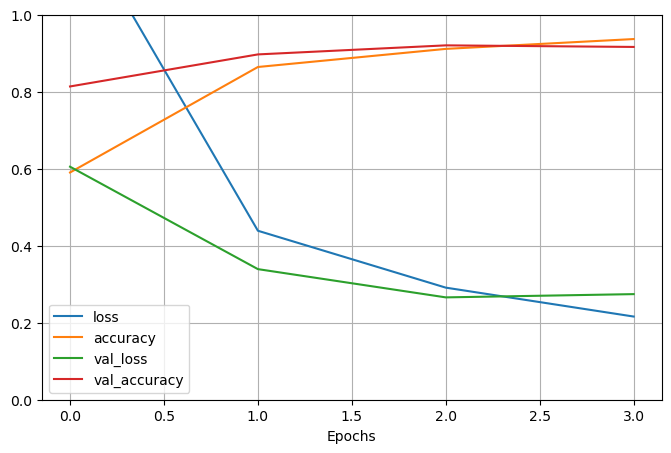

Best Accuracy: 0.9204166531562805 At Index: 2
Epoch 1/60
1500/1500 [==============================] - 4s 2ms/step - loss: 1.5710 - accuracy: 0.4740 - val_loss: 0.6860 - val_accuracy: 0.7832
Epoch 2/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5103 - accuracy: 0.8428 - val_loss: 0.3786 - val_accuracy: 0.8848
Epoch 3/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3227 - accuracy: 0.9002 - val_loss: 0.2799 - val_accuracy: 0.9140
Epoch 4/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2342 - accuracy: 0.9289 - val_loss: 0.2757 - val_accuracy: 0.9172
Epoch 5/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1797 - accuracy: 0.9466 - val_loss: 0.2459 - val_accuracy: 0.9272
Epoch 6/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1392 - accuracy: 0.9583 - val_loss: 0.2130 - val_accuracy: 0.9368
Epoch 7/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1073 - accur

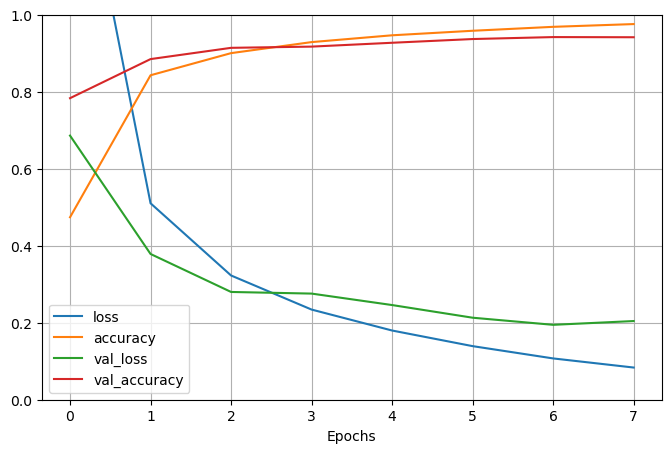

Best Accuracy: 0.9419166445732117 At Index: 6
Epoch 1/60
1500/1500 [==============================] - 5s 2ms/step - loss: 1.6815 - accuracy: 0.4322 - val_loss: 0.7836 - val_accuracy: 0.7534
Epoch 2/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5422 - accuracy: 0.8316 - val_loss: 0.3772 - val_accuracy: 0.8857
Epoch 3/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3261 - accuracy: 0.9003 - val_loss: 0.2953 - val_accuracy: 0.9114
Epoch 4/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2335 - accuracy: 0.9289 - val_loss: 0.2829 - val_accuracy: 0.9143
Epoch 5/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1770 - accuracy: 0.9465 - val_loss: 0.2425 - val_accuracy: 0.9276
Epoch 6/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1372 - accuracy: 0.9588 - val_loss: 0.2145 - val_accuracy: 0.9367
Epoch 7/60
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1049 - accur

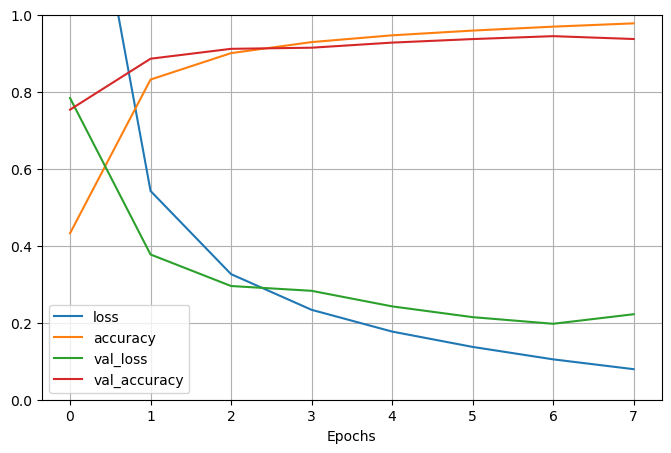

Best Accuracy: 0.9443333148956299 At Index: 6


In [66]:
models = {}
best_accuracies = []
epochs = []
for i in range(1, 11):
    history = MLP(hidden_layers=i, activation="relu", n_hidden=300, optimizer="SGD")
    models[i] = history
    accuracies = history.history['val_accuracy']
    best_acc = max(accuracies)
    best_accuracies.append(best_acc)
    idx = accuracies.index(best_acc)
    epochs.append((idx+1))

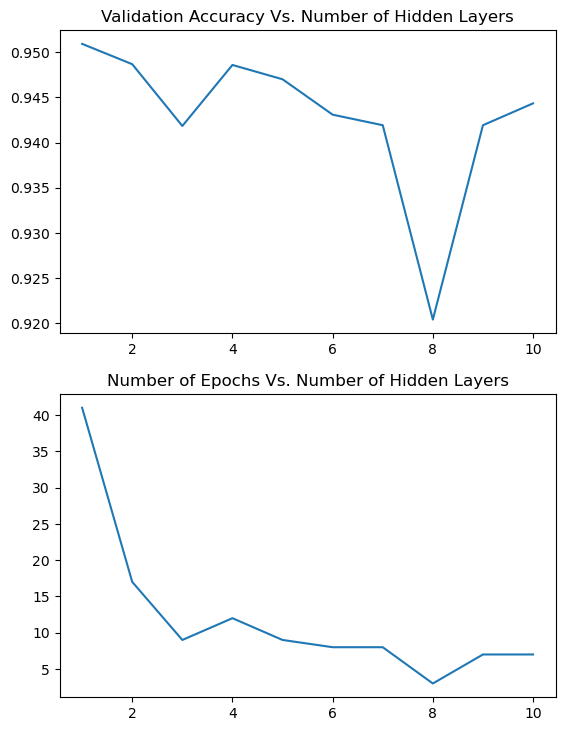

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(top=1.5)
ax1.set_title("Validation Accuracy Vs. Number of Hidden Layers")
ax2.set_title("Number of Epochs Vs. Number of Hidden Layers")
ax1.plot(models.keys(), best_accuracies)
ax2.plot(models.keys(), epochs)

Looking at this, there are a few interesting takeaways:
* The highest validation accuracy was achieved using 1 hidden layer, though it took the most epochs
* As the number of hidden layers increased, early-stopping was engaged earlier, this may be due to the fact that the optimizing algorithm changes too much from epoch to epoch, so it may make sense to:
    * Lower the learning rate (which will require more epochs to train, and since there are more layers, each epoch takes longer now)
    * Add the patience variable to the early-stopping method in order to wait a few epochs before determining that the best validation loss value has been reached

On top of it all, the more layers we add, the more patterns our network will be able to pick up on, having more layers does not necessarily imply better performance, as we can clearly see, we might even run the risk of overfitting if not for early-stopping. To explore this, let's choose a model that took a low number of epochs (6 for example) and disable early-stopping, and let it run for 30 epochs (early-stopping stopped it at 10) and see what we can discover.

Epoch 1/30
1500/1500 [==============================] - 3s 2ms/step - loss: 1.1466 - accuracy: 0.6450 - val_loss: 0.5395 - val_accuracy: 0.8328
Epoch 2/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4274 - accuracy: 0.8674 - val_loss: 0.3472 - val_accuracy: 0.8949
Epoch 3/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3019 - accuracy: 0.9087 - val_loss: 0.2809 - val_accuracy: 0.9149
Epoch 4/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2328 - accuracy: 0.9308 - val_loss: 0.2770 - val_accuracy: 0.9171
Epoch 5/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1868 - accuracy: 0.9444 - val_loss: 0.2319 - val_accuracy: 0.9305
Epoch 6/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1498 - accuracy: 0.9557 - val_loss: 0.2096 - val_accuracy: 0.9367
Epoch 7/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1216 - accuracy: 0.9634 - val_loss: 0.2013 - val_accuracy:

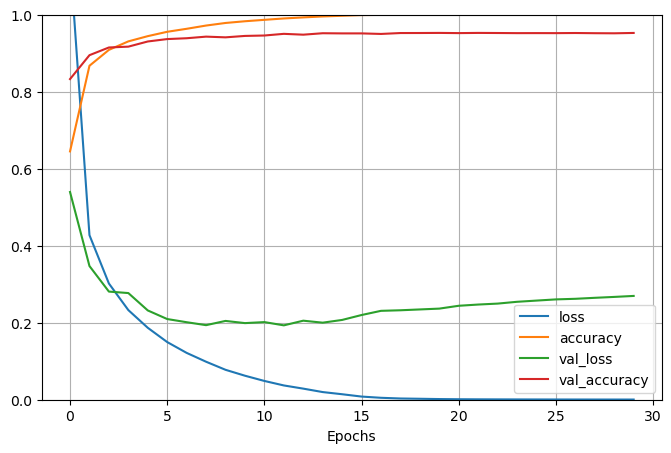

Best Accuracy: 0.952750027179718 At Index: 19
Best Accuracy: 0.952750027179718 At Index: 19


In [83]:
no_early = MLP(6, "relu", 300, "SGD", callBack=False, epochs=30)
accuracies = no_early.history['val_accuracy']
best_acc = max(accuracies)
idx = accuracies.index(best_acc)
print(f"Best Accuracy: {best_acc} At Index: {idx}")

The model overfits! To conclude, it will be okay to choose 2 as the number of hidden layers, and move on to fine-tunning other parameters. Let's explore the number of hidden neurons per hidden layer. Though this might be worth revisiting, given that there are also other parameters to tweak, and what effect they would have on this.

## Number of Neurons in Hidden Layers

Let's explore how the number of neurons affect the model's performance, to do so, we will choose 5 values (100, 200, ..., 500) and explore their effect.

Epoch 1/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.9813 - accuracy: 0.7117 - val_loss: 0.6089 - val_accuracy: 0.8188
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5210 - accuracy: 0.8445 - val_loss: 0.4742 - val_accuracy: 0.8587
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4228 - accuracy: 0.8732 - val_loss: 0.4021 - val_accuracy: 0.8786
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3620 - accuracy: 0.8926 - val_loss: 0.3649 - val_accuracy: 0.8897
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3196 - accuracy: 0.9074 - val_loss: 0.3261 - val_accuracy: 0.9031
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2870 - accuracy: 0.9162 - val_loss: 0.3032 - val_accuracy: 0.9101
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2606 - accuracy: 0.9246 - val_loss: 0.2826 - val_accuracy:

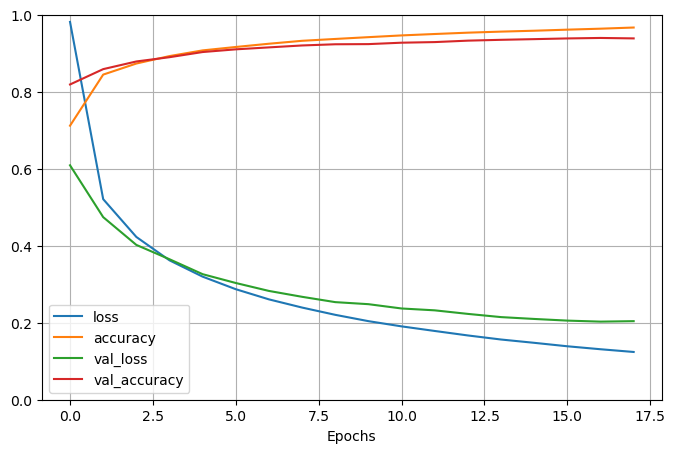

Best Accuracy: 0.9396666884422302 At Index: 16
Epoch 1/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.9401 - accuracy: 0.7307 - val_loss: 0.5943 - val_accuracy: 0.8232
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5055 - accuracy: 0.8496 - val_loss: 0.4603 - val_accuracy: 0.8626
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4051 - accuracy: 0.8794 - val_loss: 0.3877 - val_accuracy: 0.8851
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3434 - accuracy: 0.8982 - val_loss: 0.3580 - val_accuracy: 0.8917
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3008 - accuracy: 0.9126 - val_loss: 0.3104 - val_accuracy: 0.9088
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2670 - accuracy: 0.9221 - val_loss: 0.2870 - val_accuracy: 0.9151
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2392 - accu

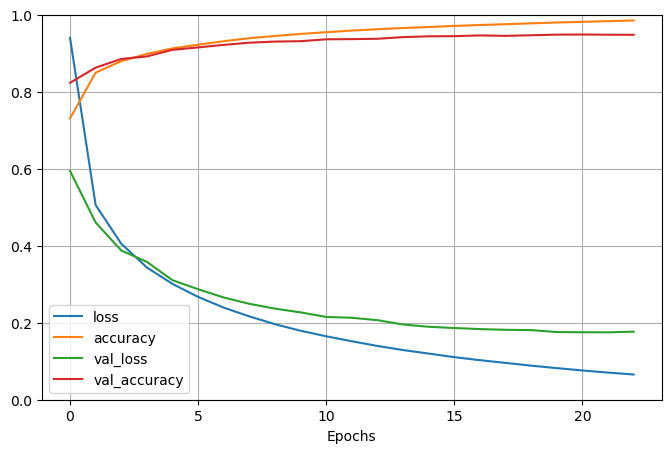

Best Accuracy: 0.9485833048820496 At Index: 20
Epoch 1/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.8998 - accuracy: 0.7470 - val_loss: 0.5722 - val_accuracy: 0.8312
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4861 - accuracy: 0.8562 - val_loss: 0.4440 - val_accuracy: 0.8678
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3899 - accuracy: 0.8850 - val_loss: 0.3739 - val_accuracy: 0.8915
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3309 - accuracy: 0.9024 - val_loss: 0.3417 - val_accuracy: 0.8978
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2895 - accuracy: 0.9156 - val_loss: 0.3026 - val_accuracy: 0.9110
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2560 - accuracy: 0.9260 - val_loss: 0.2784 - val_accuracy: 0.9184
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2288 - accu

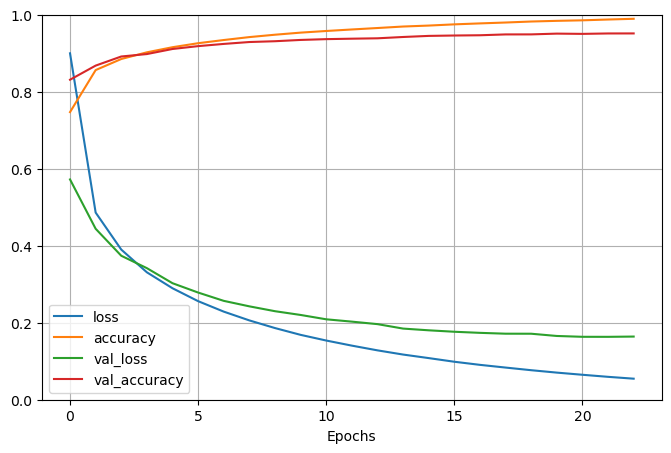

Best Accuracy: 0.9514166712760925 At Index: 22
Epoch 1/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.8984 - accuracy: 0.7470 - val_loss: 0.5698 - val_accuracy: 0.8303
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4850 - accuracy: 0.8564 - val_loss: 0.4415 - val_accuracy: 0.8702
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3896 - accuracy: 0.8842 - val_loss: 0.3729 - val_accuracy: 0.8915
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3308 - accuracy: 0.9029 - val_loss: 0.3395 - val_accuracy: 0.8981
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2886 - accuracy: 0.9160 - val_loss: 0.3001 - val_accuracy: 0.9108
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2548 - accuracy: 0.9264 - val_loss: 0.2750 - val_accuracy: 0.9177
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2265 - accu

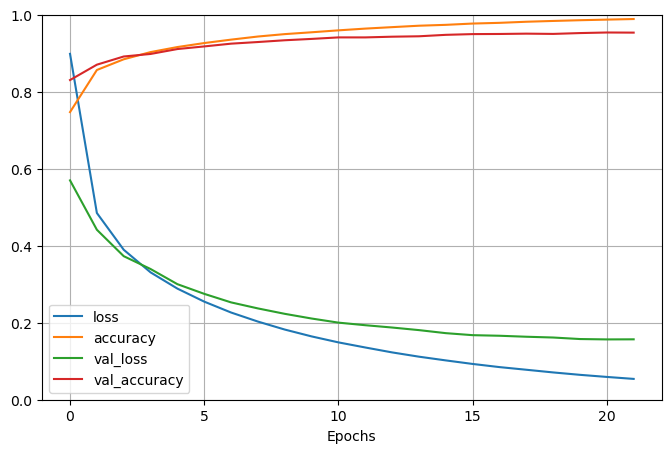

Best Accuracy: 0.9538333415985107 At Index: 20
Epoch 1/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.8615 - accuracy: 0.7597 - val_loss: 0.5547 - val_accuracy: 0.8356
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4730 - accuracy: 0.8613 - val_loss: 0.4369 - val_accuracy: 0.8702
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3812 - accuracy: 0.8877 - val_loss: 0.3681 - val_accuracy: 0.8920
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3232 - accuracy: 0.9049 - val_loss: 0.3360 - val_accuracy: 0.9016
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2815 - accuracy: 0.9188 - val_loss: 0.2966 - val_accuracy: 0.9133
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2478 - accuracy: 0.9293 - val_loss: 0.2734 - val_accuracy: 0.9198
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2198 - accu

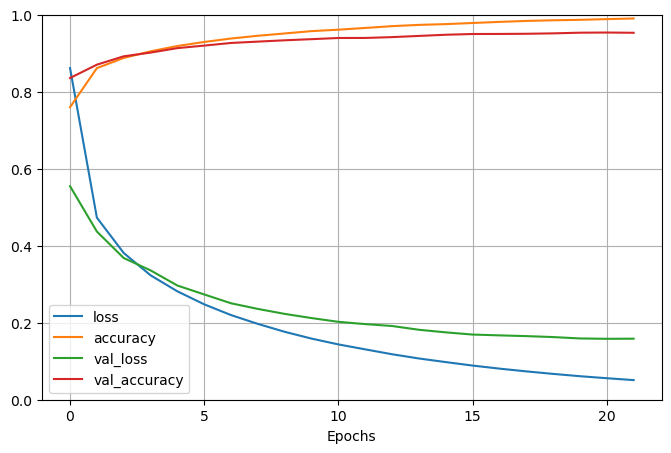

Best Accuracy: 0.9537500143051147 At Index: 20


In [80]:
models.clear()
best_accuracies.clear()
epochs.clear()
neurons = [i*100 for i in range(1,6)]
for i in neurons:
    history = MLP(2, "relu", i, "SGD")
    models[i] = history
    accuracies = history.history['val_accuracy']
    best_acc = max(accuracies)
    best_accuracies.append(best_acc)
    idx = accuracies.index(best_acc)
    epochs.append((idx+1))

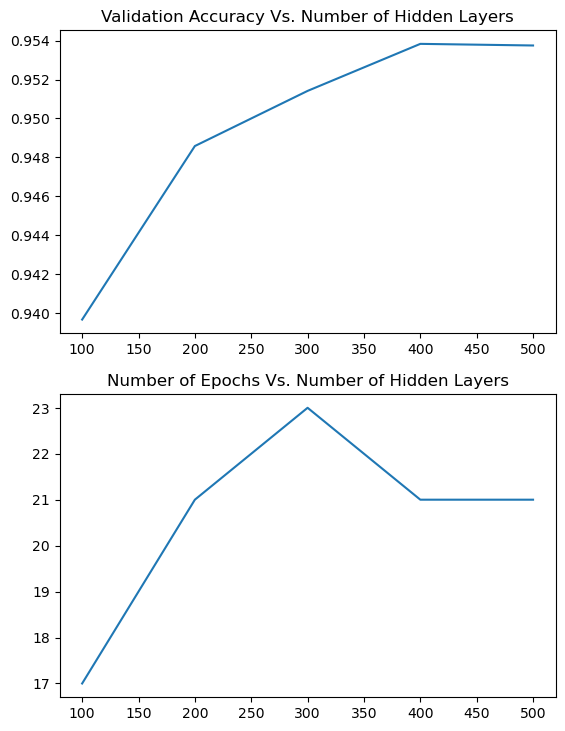

In [81]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(top=1.5)
ax1.set_title("Validation Accuracy Vs. Number of Neurons")
ax2.set_title("Number of Epochs Vs. Number of Neurons")
ax1.plot(models.keys(), best_accuracies)
ax2.plot(models.keys(), epochs)

The increase number of neurons per hidden layer does in fact lead to an improvement, both in validation accuracy and number of epochs needed to reach it, but of course this does have an upper bound, and we seem to reach it when the number of neurons is 400. We choose that as our best value and move on to the next parameter.

## Optimizer

We will now move on to the optimizer that will be used. We will start by exploring Gradient Descent with Momentum, which essentially determines what portion of the learning rate from the previous iteration to add on top of the learning rate, this is repeated until the gradient changes direction, in which case it "slows" down. We will stick to using the default learning rate of 0.01, and experiment with different momentum values. It is a good idea to present the equation of how gradient descent updates the weights, this is as follows:
$$w = w - \text{learning\_rate} * g$$
When using momentum, the update rule changes into:
$$w = w + \text{velocity}$$
$$\text{velocity} = \text{momentum} * \text{velocity} - \text{learning\_rate} * g$$

We will experiment with 3 different values (0.1, 0.2, 0.3) and consider their effect on the validation accuracy and number of epochs.

Epoch 1/60


2024-05-08 01:26:53.524774: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.
2024-05-08 01:26:53.648545: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


1500/1500 [==============================] - 2s 1ms/step - loss: 0.8555 - accuracy: 0.7591 - val_loss: 0.5359 - val_accuracy: 0.8432
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4561 - accuracy: 0.8654 - val_loss: 0.4120 - val_accuracy: 0.8778
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3633 - accuracy: 0.8929 - val_loss: 0.3478 - val_accuracy: 0.8972
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3066 - accuracy: 0.9111 - val_loss: 0.3180 - val_accuracy: 0.9053
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2660 - accuracy: 0.9228 - val_loss: 0.2759 - val_accuracy: 0.9199
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2331 - accuracy: 0.9334 - val_loss: 0.2560 - val_accuracy: 0.9240
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2060 - accuracy: 0.9418 - val_loss: 0.2345 - val_accuracy: 0.9310
Epo

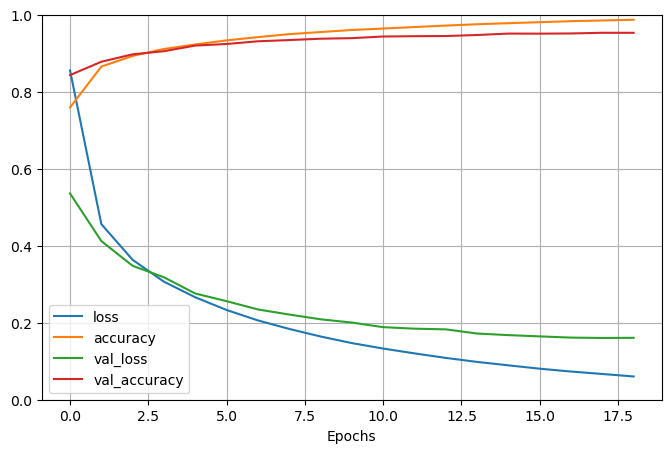

Best Accuracy: 0.953083336353302 At Index: 17
Epoch 1/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.8129 - accuracy: 0.7693 - val_loss: 0.5282 - val_accuracy: 0.8422
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4469 - accuracy: 0.8673 - val_loss: 0.4073 - val_accuracy: 0.8783
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3557 - accuracy: 0.8953 - val_loss: 0.3436 - val_accuracy: 0.8988
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2986 - accuracy: 0.9129 - val_loss: 0.3111 - val_accuracy: 0.9057
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2575 - accuracy: 0.9250 - val_loss: 0.2738 - val_accuracy: 0.9197
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2241 - accuracy: 0.9359 - val_loss: 0.2551 - val_accuracy: 0.9231
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1965 - accur

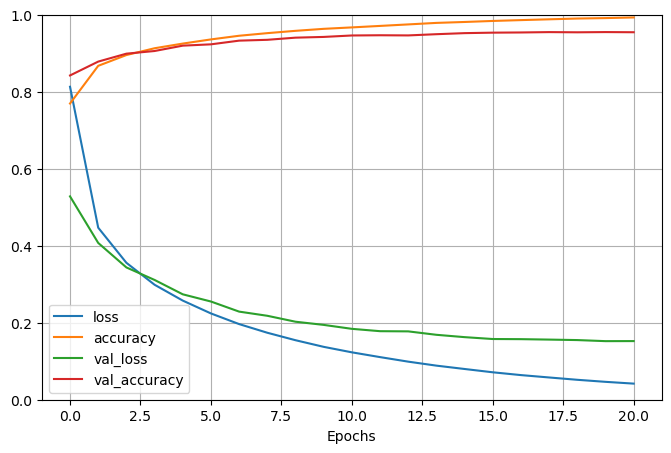

Best Accuracy: 0.9549166560173035 At Index: 19
Epoch 1/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.7772 - accuracy: 0.7776 - val_loss: 0.5046 - val_accuracy: 0.8497
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4233 - accuracy: 0.8735 - val_loss: 0.3870 - val_accuracy: 0.8846
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3306 - accuracy: 0.9026 - val_loss: 0.3208 - val_accuracy: 0.9043
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2725 - accuracy: 0.9214 - val_loss: 0.2987 - val_accuracy: 0.9095
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2316 - accuracy: 0.9330 - val_loss: 0.2475 - val_accuracy: 0.9286
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1988 - accuracy: 0.9441 - val_loss: 0.2323 - val_accuracy: 0.9313
Epoch 7/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1725 - accu

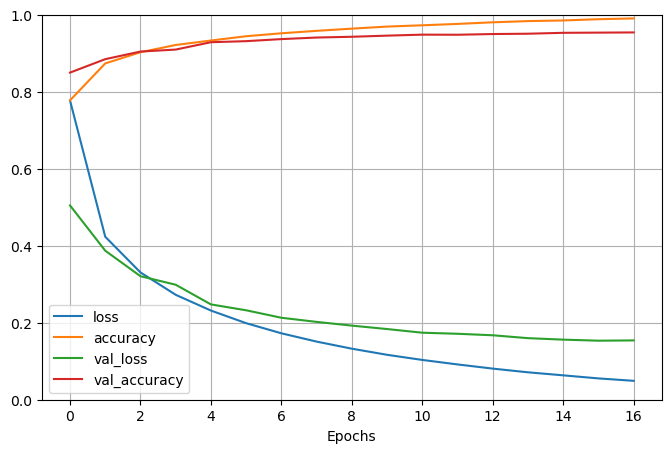

Best Accuracy: 0.9539999961853027 At Index: 16


In [17]:
momentums = [0.1, 0.2, 0.3]
best_accuracies = []
epochs = []
for i in momentums:
    history = MLP(2, "relu", 400, "SGD", momentum=i)
    accuracies = history.history['val_accuracy']
    best_acc = max(accuracies)
    best_accuracies.append(best_acc)
    idx = accuracies.index(best_acc)
    epochs.append((idx+1))
    

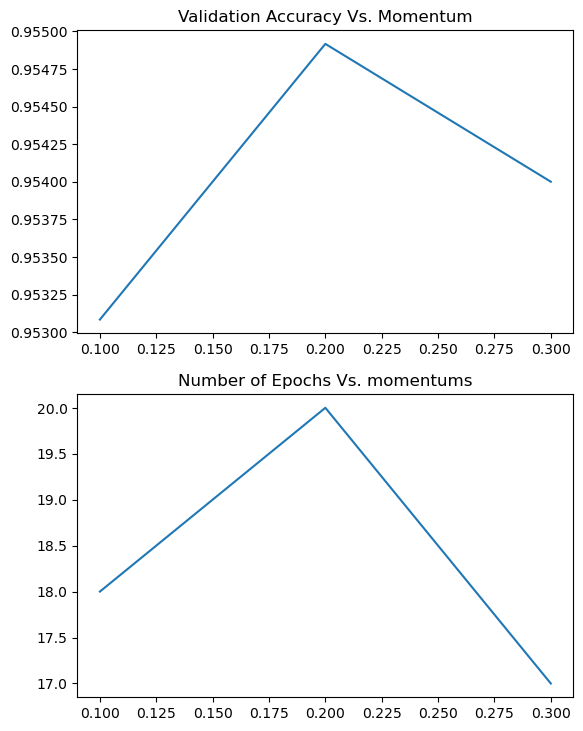

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(top=1.5)
ax1.set_title("Validation Accuracy Vs. Momentum")
ax2.set_title("Number of Epochs Vs. momentums")
ax1.plot(momentums, best_accuracies)
ax2.plot(momentums, epochs)

We see here that momentum can improve gradient descent, but requires a lot of tuning. Let's try the Adam optimizer with the default learning rate (0.001) and see what we find:

Epoch 1/60
1500/1500 [==============================] - 3s 1ms/step - loss: 0.3271 - accuracy: 0.8985 - val_loss: 0.1933 - val_accuracy: 0.9392
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1409 - accuracy: 0.9563 - val_loss: 0.1681 - val_accuracy: 0.9498
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0873 - accuracy: 0.9737 - val_loss: 0.1631 - val_accuracy: 0.9523
Epoch 4/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0602 - accuracy: 0.9817 - val_loss: 0.1604 - val_accuracy: 0.9566
Epoch 5/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0473 - accuracy: 0.9850 - val_loss: 0.1593 - val_accuracy: 0.9594
Epoch 6/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0372 - accuracy: 0.9883 - val_loss: 0.1707 - val_accuracy: 0.9595


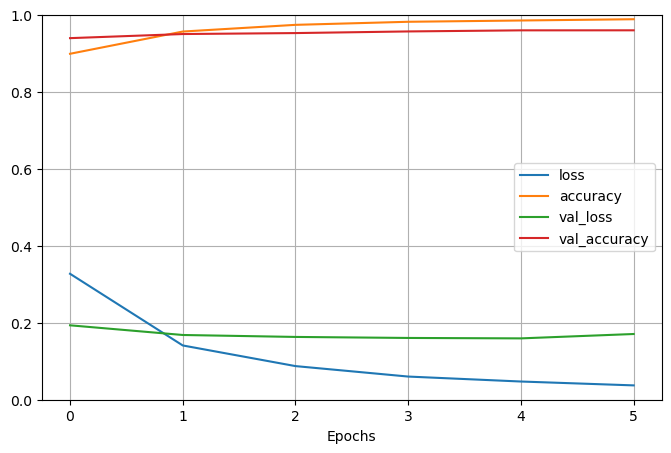

Best Accuracy: 0.9595000147819519 At Index: 5


In [20]:
history = MLP(2, "relu", 400, "Adam", learning_rate=0.001)

This performs better than previous attempts with gradient descent! We will choose this as the best one and move on to the next parameter.

## Batch-Size

For this, we will use multiples of 16, and perform similar analysis to the previous parameters:

Epoch 1/60
3000/3000 [==============================] - 5s 1ms/step - loss: 0.3196 - accuracy: 0.9012 - val_loss: 0.1993 - val_accuracy: 0.9395
Epoch 2/60
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1428 - accuracy: 0.9558 - val_loss: 0.1614 - val_accuracy: 0.9510
Epoch 3/60
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0940 - accuracy: 0.9699 - val_loss: 0.1868 - val_accuracy: 0.9504


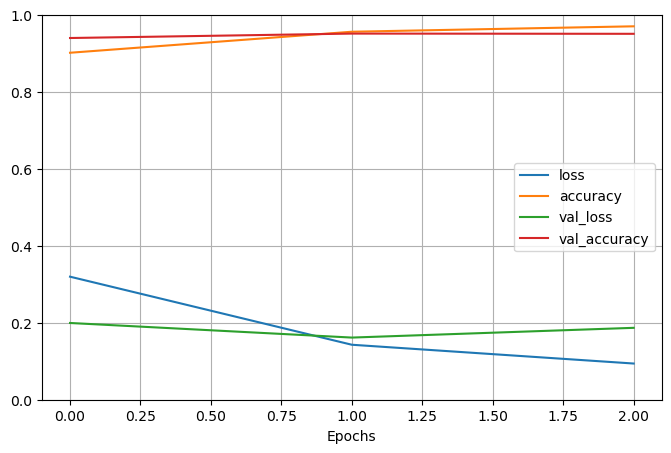

Best Accuracy: 0.9509999752044678 At Index: 1
Epoch 1/60
1500/1500 [==============================] - 3s 1ms/step - loss: 0.3243 - accuracy: 0.9005 - val_loss: 0.1948 - val_accuracy: 0.9388
Epoch 2/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1374 - accuracy: 0.9581 - val_loss: 0.1642 - val_accuracy: 0.9488
Epoch 3/60
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0848 - accuracy: 0.9738 - val_loss: 0.1756 - val_accuracy: 0.9511


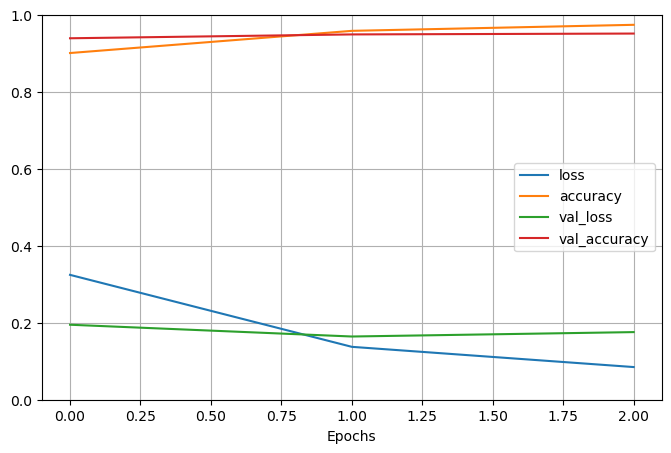

Best Accuracy: 0.9510833621025085 At Index: 2
Epoch 1/60
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3368 - accuracy: 0.8957 - val_loss: 0.2116 - val_accuracy: 0.9325
Epoch 2/60
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1378 - accuracy: 0.9582 - val_loss: 0.1696 - val_accuracy: 0.9492
Epoch 3/60
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0842 - accuracy: 0.9736 - val_loss: 0.1683 - val_accuracy: 0.9510
Epoch 4/60
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0557 - accuracy: 0.9821 - val_loss: 0.1749 - val_accuracy: 0.9523


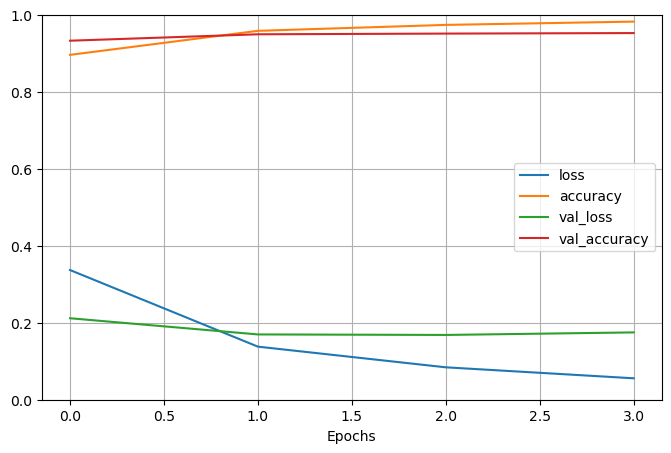

Best Accuracy: 0.9523333311080933 At Index: 3
Epoch 1/60
750/750 [==============================] - 2s 2ms/step - loss: 0.3482 - accuracy: 0.8942 - val_loss: 0.2102 - val_accuracy: 0.9342
Epoch 2/60
750/750 [==============================] - 1s 1ms/step - loss: 0.1419 - accuracy: 0.9567 - val_loss: 0.1632 - val_accuracy: 0.9505
Epoch 3/60
750/750 [==============================] - 1s 1ms/step - loss: 0.0845 - accuracy: 0.9741 - val_loss: 0.1461 - val_accuracy: 0.9566
Epoch 4/60
750/750 [==============================] - 1s 1ms/step - loss: 0.0551 - accuracy: 0.9825 - val_loss: 0.1523 - val_accuracy: 0.9566


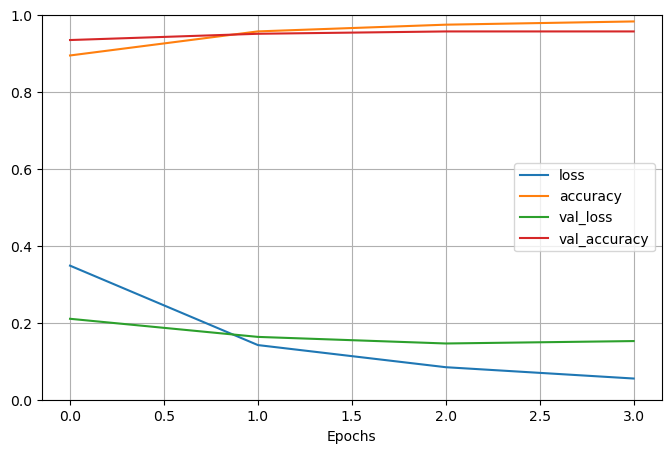

Best Accuracy: 0.9565833210945129 At Index: 2


In [21]:
sizes = [i*16 for i in range(1, 5)]
best_accuracies = []
epochs = []
for i in sizes:
    history = MLP(2, "relu", 400, "Adam", learning_rate=0.001, miniBatch=i)
    accuracies = history.history['val_accuracy']
    best_acc = max(accuracies)
    best_accuracies.append(best_acc)
    idx = accuracies.index(best_acc)
    epochs.append((idx+1))

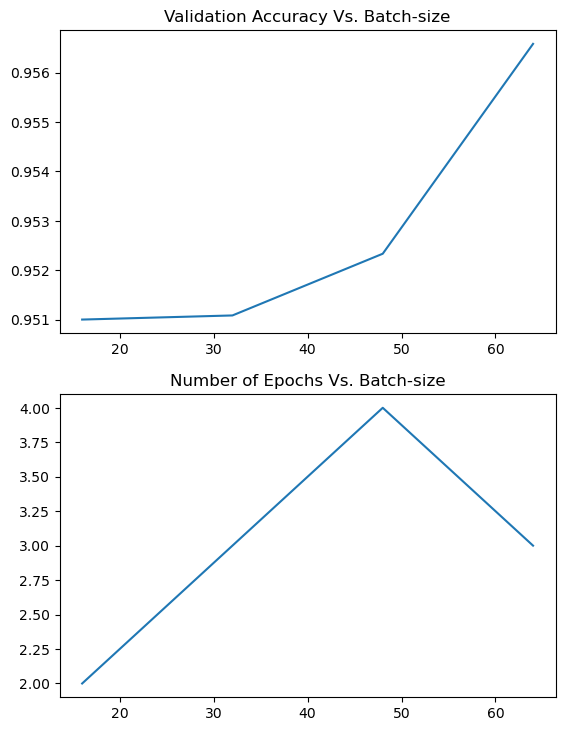

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(top=1.5)
ax1.set_title("Validation Accuracy Vs. Batch-size")
ax2.set_title("Number of Epochs Vs. Batch-size")
ax1.plot(sizes, best_accuracies)
ax2.plot(sizes, epochs)

Rather peculiar! It seems that we achieved the best accuracy, and lowest epoch with the highest batch size (64), let's keep trying with higher values and see what we find:

Epoch 1/60


2024-05-08 02:01:11.107778: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f988c2d8fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 02:01:11.107809: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2024-05-08 02:01:11.107817: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2024-05-08 02:01:11.112717: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-08 02:01:11.126604: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1715126471.185400  110673 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 [==============================] - 2s 2ms/step - loss: 0.3465 - accuracy: 0.8944 - val_loss: 0.2080 - val_accuracy: 0.9342
Epoch 2/60
750/750 [==============================] - 1s 1ms/step - loss: 0.1416 - accuracy: 0.9566 - val_loss: 0.1696 - val_accuracy: 0.9479
Epoch 3/60
750/750 [==============================] - 1s 1ms/step - loss: 0.0824 - accuracy: 0.9750 - val_loss: 0.1519 - val_accuracy: 0.9555
Epoch 4/60
750/750 [==============================] - 1s 1ms/step - loss: 0.0554 - accuracy: 0.9822 - val_loss: 0.1615 - val_accuracy: 0.9553


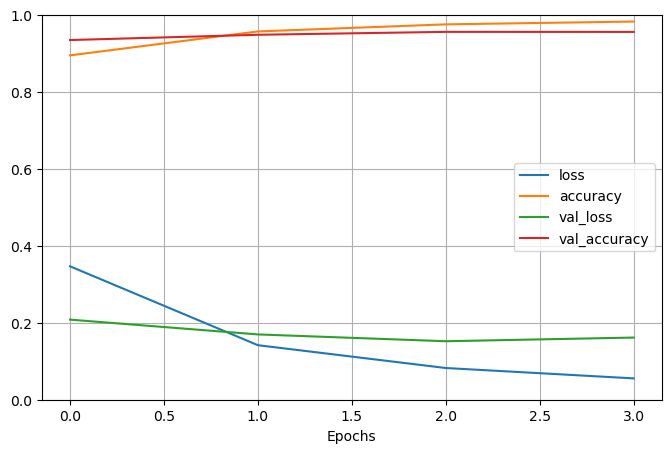

Best Accuracy: 0.9555000066757202 At Index: 2
Epoch 1/60
600/600 [==============================] - 2s 2ms/step - loss: 0.3625 - accuracy: 0.8893 - val_loss: 0.2192 - val_accuracy: 0.9345
Epoch 2/60
600/600 [==============================] - 1s 1ms/step - loss: 0.1452 - accuracy: 0.9554 - val_loss: 0.1667 - val_accuracy: 0.9495
Epoch 3/60
600/600 [==============================] - 1s 1ms/step - loss: 0.0855 - accuracy: 0.9735 - val_loss: 0.1531 - val_accuracy: 0.9541
Epoch 4/60
600/600 [==============================] - 1s 1ms/step - loss: 0.0545 - accuracy: 0.9833 - val_loss: 0.1662 - val_accuracy: 0.9544


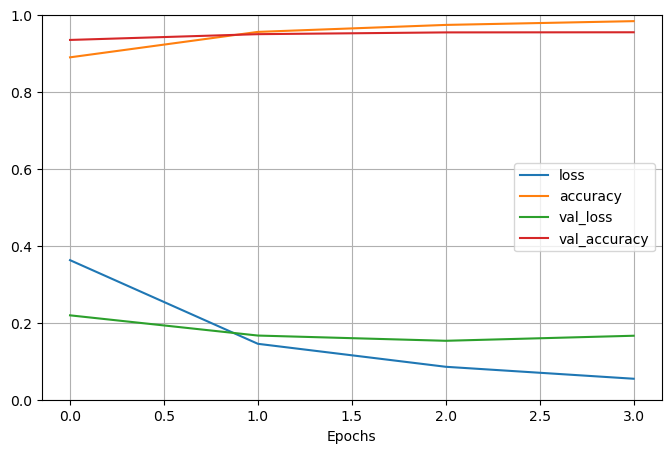

Best Accuracy: 0.9544166922569275 At Index: 3
Epoch 1/60
500/500 [==============================] - 1s 2ms/step - loss: 0.3778 - accuracy: 0.8843 - val_loss: 0.2333 - val_accuracy: 0.9274
Epoch 2/60
500/500 [==============================] - 1s 1ms/step - loss: 0.1502 - accuracy: 0.9551 - val_loss: 0.1717 - val_accuracy: 0.9463
Epoch 3/60
500/500 [==============================] - 1s 2ms/step - loss: 0.0879 - accuracy: 0.9733 - val_loss: 0.1558 - val_accuracy: 0.9541
Epoch 4/60
500/500 [==============================] - 1s 2ms/step - loss: 0.0546 - accuracy: 0.9838 - val_loss: 0.1466 - val_accuracy: 0.9580
Epoch 5/60
500/500 [==============================] - 1s 1ms/step - loss: 0.0360 - accuracy: 0.9885 - val_loss: 0.1575 - val_accuracy: 0.9564


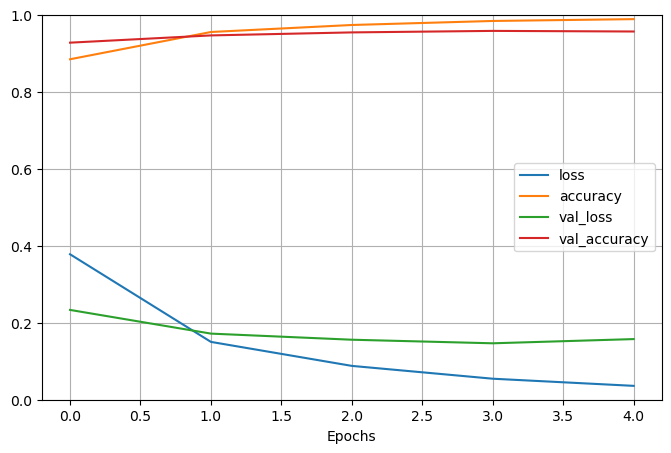

Best Accuracy: 0.9580000042915344 At Index: 3
Epoch 1/60
429/429 [==============================] - 1s 2ms/step - loss: 0.3858 - accuracy: 0.8828 - val_loss: 0.2199 - val_accuracy: 0.9335
Epoch 2/60
429/429 [==============================] - 1s 2ms/step - loss: 0.1500 - accuracy: 0.9556 - val_loss: 0.1667 - val_accuracy: 0.9484
Epoch 3/60
429/429 [==============================] - 1s 2ms/step - loss: 0.0875 - accuracy: 0.9737 - val_loss: 0.1535 - val_accuracy: 0.9555
Epoch 4/60
429/429 [==============================] - 1s 2ms/step - loss: 0.0554 - accuracy: 0.9837 - val_loss: 0.1600 - val_accuracy: 0.9535


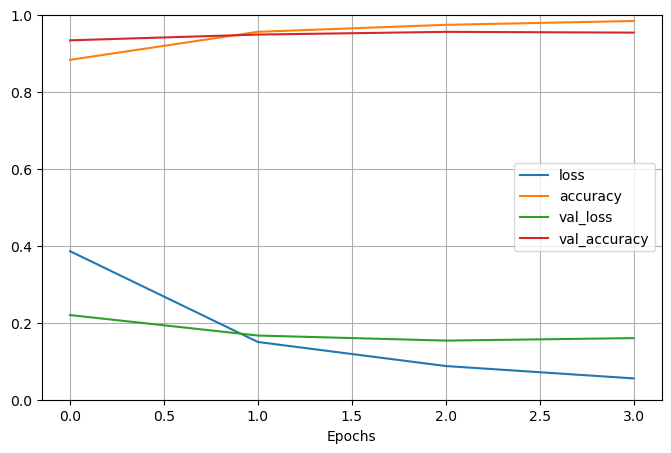

Best Accuracy: 0.9555000066757202 At Index: 2
Epoch 1/60
375/375 [==============================] - 1s 2ms/step - loss: 0.3996 - accuracy: 0.8789 - val_loss: 0.2460 - val_accuracy: 0.9253
Epoch 2/60
375/375 [==============================] - 1s 2ms/step - loss: 0.1590 - accuracy: 0.9531 - val_loss: 0.1843 - val_accuracy: 0.9423
Epoch 3/60
375/375 [==============================] - 1s 2ms/step - loss: 0.0944 - accuracy: 0.9725 - val_loss: 0.1507 - val_accuracy: 0.9557
Epoch 4/60
375/375 [==============================] - 1s 2ms/step - loss: 0.0568 - accuracy: 0.9833 - val_loss: 0.1423 - val_accuracy: 0.9597
Epoch 5/60
375/375 [==============================] - 1s 2ms/step - loss: 0.0370 - accuracy: 0.9884 - val_loss: 0.1572 - val_accuracy: 0.9558


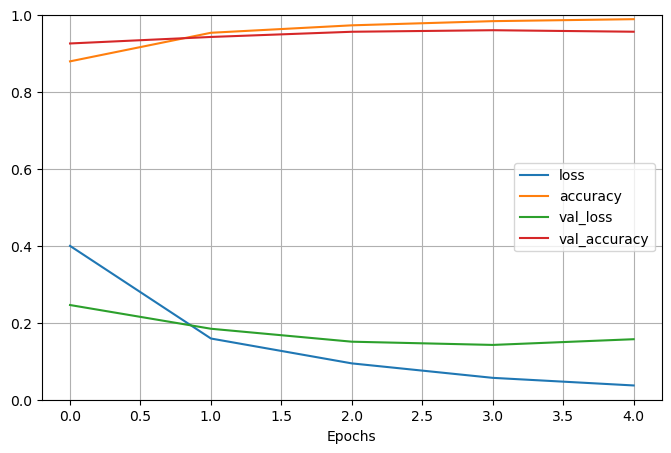

Best Accuracy: 0.9597499966621399 At Index: 3


In [15]:
sizes = [i*16 for i in range(4, 9)]
best_accuracies = []
epochs = []
for i in sizes:
    history = MLP(2, "relu", 400, "Adam", learning_rate=0.001, miniBatch=i)
    accuracies = history.history['val_accuracy']
    best_acc = max(accuracies)
    best_accuracies.append(best_acc)
    idx = accuracies.index(best_acc)
    epochs.append((idx+1))

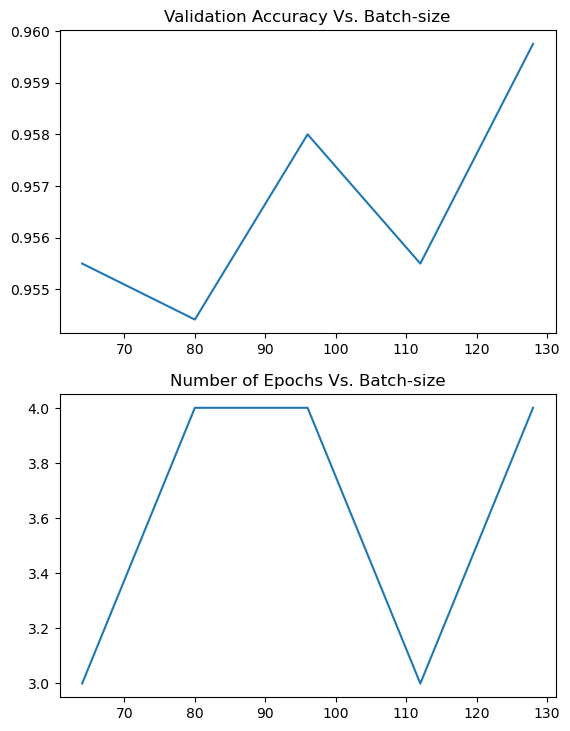

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(top=1.5)
ax1.set_title("Validation Accuracy Vs. Batch-size")
ax2.set_title("Number of Epochs Vs. Batch-size")
ax1.plot(sizes, best_accuracies)
ax2.plot(sizes, epochs)

From this, we conclude that 128 is the best batch size.

## Learning Rate

We will now move on from parameters that do with the structure of the network itself into ones that deal with training, i.e. hyperparameters, the first one we will look at is the learning rate. By default the learning rate is set to 0.01 when using Stochastic Gradient Descent, however this can be adjusted. Let's try 5 different learning rates and see how our training process goes. 

Epoch 1/60
375/375 [==============================] - 1s 2ms/step - loss: 0.4791 - accuracy: 0.8581 - val_loss: 0.2750 - val_accuracy: 0.9162
Epoch 2/60
375/375 [==============================] - 1s 2ms/step - loss: 0.2072 - accuracy: 0.9401 - val_loss: 0.1993 - val_accuracy: 0.9411
Epoch 3/60
375/375 [==============================] - 1s 2ms/step - loss: 0.1327 - accuracy: 0.9613 - val_loss: 0.1605 - val_accuracy: 0.9520
Epoch 4/60
375/375 [==============================] - 1s 2ms/step - loss: 0.0871 - accuracy: 0.9754 - val_loss: 0.1502 - val_accuracy: 0.9557
Epoch 5/60
375/375 [==============================] - 1s 2ms/step - loss: 0.0589 - accuracy: 0.9843 - val_loss: 0.1534 - val_accuracy: 0.9562


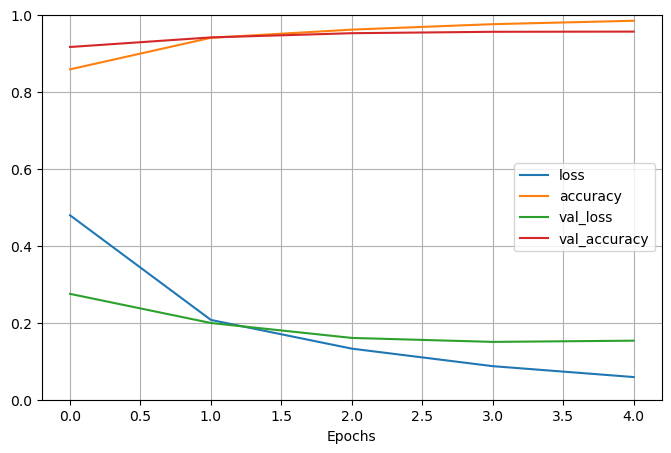

Best Accuracy: 0.956166684627533 At Index: 4
Epoch 1/60
375/375 [==============================] - 1s 2ms/step - loss: 0.4014 - accuracy: 0.8797 - val_loss: 0.2401 - val_accuracy: 0.9258
Epoch 2/60
375/375 [==============================] - 1s 2ms/step - loss: 0.1600 - accuracy: 0.9523 - val_loss: 0.1863 - val_accuracy: 0.9419
Epoch 3/60
375/375 [==============================] - 1s 2ms/step - loss: 0.0956 - accuracy: 0.9719 - val_loss: 0.1589 - val_accuracy: 0.9535
Epoch 4/60
375/375 [==============================] - 1s 2ms/step - loss: 0.0569 - accuracy: 0.9828 - val_loss: 0.1469 - val_accuracy: 0.9565
Epoch 5/60
375/375 [==============================] - 1s 2ms/step - loss: 0.0377 - accuracy: 0.9882 - val_loss: 0.1569 - val_accuracy: 0.9582


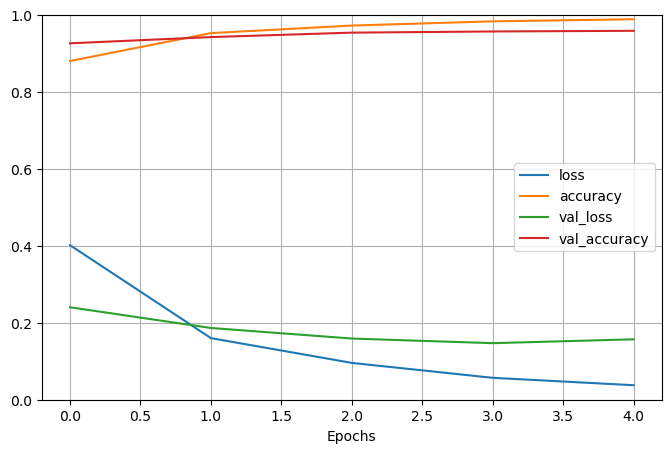

Best Accuracy: 0.9582499861717224 At Index: 4
Epoch 1/60
375/375 [==============================] - 1s 2ms/step - loss: 0.3497 - accuracy: 0.8933 - val_loss: 0.2129 - val_accuracy: 0.9329
Epoch 2/60
375/375 [==============================] - 1s 2ms/step - loss: 0.1442 - accuracy: 0.9558 - val_loss: 0.1693 - val_accuracy: 0.9483
Epoch 3/60
375/375 [==============================] - 1s 2ms/step - loss: 0.0863 - accuracy: 0.9738 - val_loss: 0.1626 - val_accuracy: 0.9548
Epoch 4/60
375/375 [==============================] - 1s 2ms/step - loss: 0.0578 - accuracy: 0.9816 - val_loss: 0.1741 - val_accuracy: 0.9518


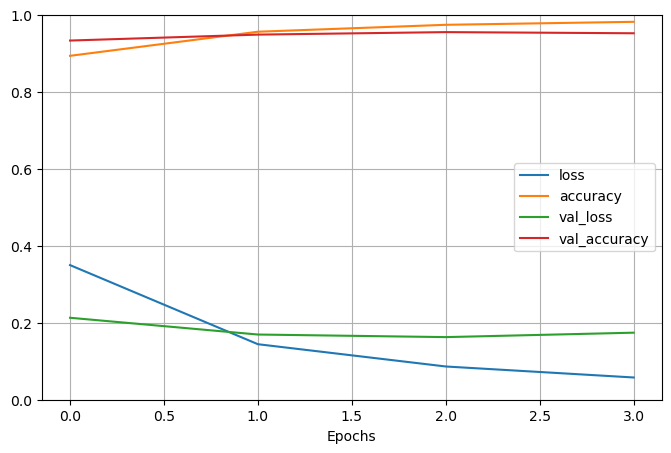

Best Accuracy: 0.9548333287239075 At Index: 2
Epoch 1/60
375/375 [==============================] - 1s 2ms/step - loss: 0.3550 - accuracy: 0.8903 - val_loss: 0.2440 - val_accuracy: 0.9245
Epoch 2/60
375/375 [==============================] - 1s 2ms/step - loss: 0.1698 - accuracy: 0.9497 - val_loss: 0.1955 - val_accuracy: 0.9423
Epoch 3/60
375/375 [==============================] - 1s 2ms/step - loss: 0.1216 - accuracy: 0.9631 - val_loss: 0.1905 - val_accuracy: 0.9484
Epoch 4/60
375/375 [==============================] - 1s 2ms/step - loss: 0.1034 - accuracy: 0.9680 - val_loss: 0.2022 - val_accuracy: 0.9469


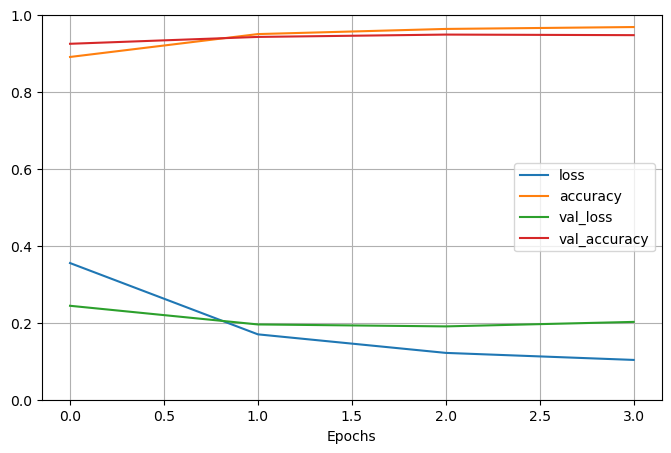

Best Accuracy: 0.9484166502952576 At Index: 2
Epoch 1/60
375/375 [==============================] - 1s 2ms/step - loss: 0.3880 - accuracy: 0.8819 - val_loss: 0.2462 - val_accuracy: 0.9250
Epoch 2/60
375/375 [==============================] - 1s 2ms/step - loss: 0.1956 - accuracy: 0.9410 - val_loss: 0.2573 - val_accuracy: 0.9249


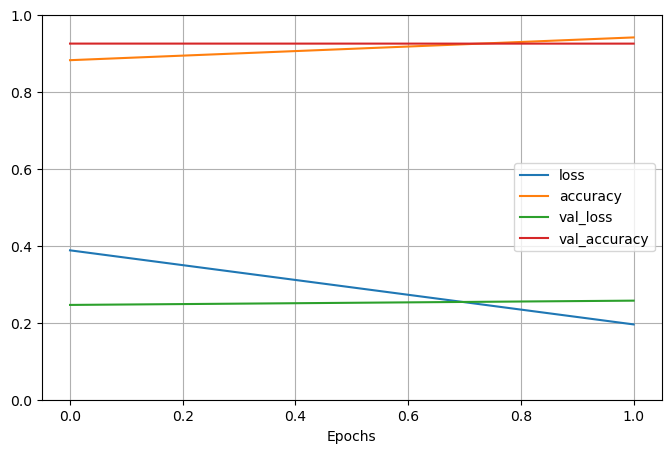

Best Accuracy: 0.925000011920929 At Index: 0
Epoch 1/60
375/375 [==============================] - 2s 2ms/step - loss: 0.4308 - accuracy: 0.8713 - val_loss: 0.3006 - val_accuracy: 0.9111
Epoch 2/60
375/375 [==============================] - 1s 2ms/step - loss: 0.2433 - accuracy: 0.9285 - val_loss: 0.2818 - val_accuracy: 0.9198
Epoch 3/60
375/375 [==============================] - 1s 2ms/step - loss: 0.2052 - accuracy: 0.9413 - val_loss: 0.2566 - val_accuracy: 0.9307
Epoch 4/60
375/375 [==============================] - 1s 2ms/step - loss: 0.1782 - accuracy: 0.9489 - val_loss: 0.2677 - val_accuracy: 0.9349


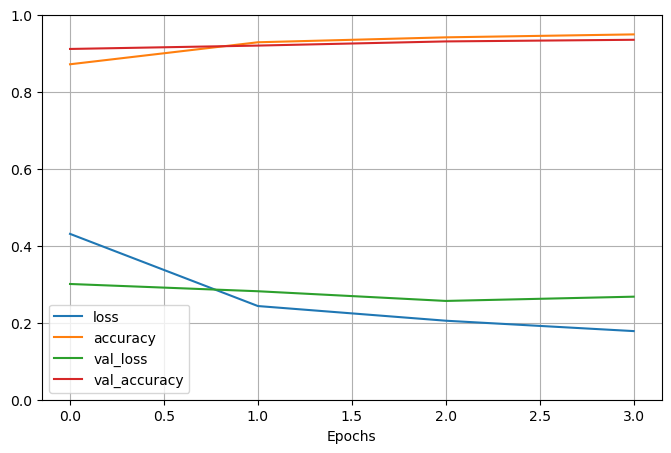

Best Accuracy: 0.9349166750907898 At Index: 3


In [17]:
learning_rates = [0.0005, 0.001, 0.002, 0.005, 0.007, 0.01]
best_accuracies = []
epochs = []
for i in learning_rates:
    history = MLP(2, "relu", 400, "Adam", i, miniBatch=128)
    accuracies = history.history['val_accuracy']
    best_acc = max(accuracies)
    best_accuracies.append(best_acc)
    idx = accuracies.index(best_acc)
    epochs.append((idx+1))
    

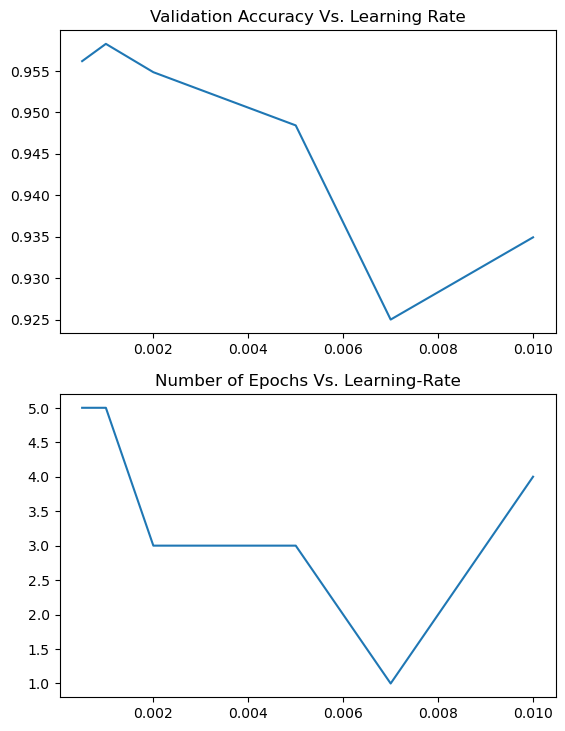

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(top=1.5)
ax1.set_title("Validation Accuracy Vs. Learning Rate")
ax2.set_title("Number of Epochs Vs. Learning-Rate")
ax1.plot(learning_rates, best_accuracies)
ax2.plot(learning_rates, epochs)

Interesting observation, let's do our experiments again but with a batch size of 64, and see what we can find:

Epoch 1/60
750/750 [==============================] - 2s 2ms/step - loss: 0.4111 - accuracy: 0.8778 - val_loss: 0.2437 - val_accuracy: 0.9262
Epoch 2/60
750/750 [==============================] - 1s 2ms/step - loss: 0.1707 - accuracy: 0.9491 - val_loss: 0.1811 - val_accuracy: 0.9452
Epoch 3/60
750/750 [==============================] - 1s 2ms/step - loss: 0.1040 - accuracy: 0.9695 - val_loss: 0.1558 - val_accuracy: 0.9540
Epoch 4/60
750/750 [==============================] - 1s 2ms/step - loss: 0.0667 - accuracy: 0.9801 - val_loss: 0.1615 - val_accuracy: 0.9522


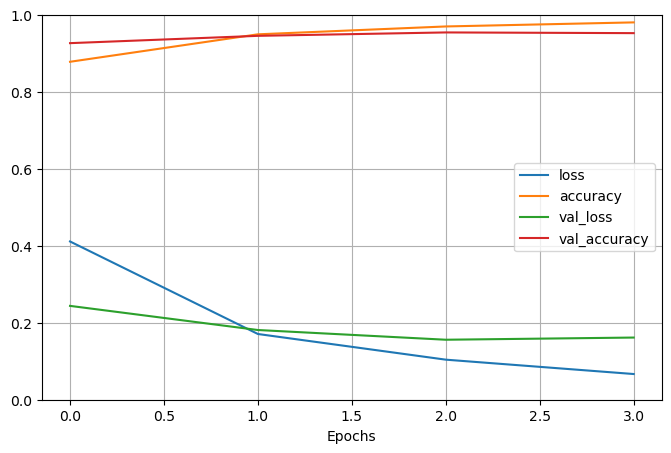

Best Accuracy: 0.9539999961853027 At Index: 2
Epoch 1/60
750/750 [==============================] - 2s 2ms/step - loss: 0.3454 - accuracy: 0.8943 - val_loss: 0.2103 - val_accuracy: 0.9340
Epoch 2/60
750/750 [==============================] - 1s 1ms/step - loss: 0.1394 - accuracy: 0.9571 - val_loss: 0.1685 - val_accuracy: 0.9502
Epoch 3/60
750/750 [==============================] - 1s 1ms/step - loss: 0.0821 - accuracy: 0.9749 - val_loss: 0.1595 - val_accuracy: 0.9539
Epoch 4/60
750/750 [==============================] - 1s 1ms/step - loss: 0.0532 - accuracy: 0.9835 - val_loss: 0.1652 - val_accuracy: 0.9558


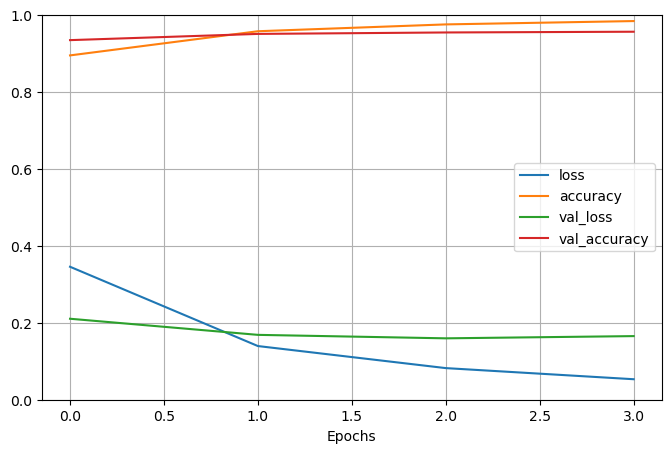

Best Accuracy: 0.9558333158493042 At Index: 3
Epoch 1/60
750/750 [==============================] - 2s 2ms/step - loss: 0.3258 - accuracy: 0.8988 - val_loss: 0.2185 - val_accuracy: 0.9348
Epoch 2/60
750/750 [==============================] - 1s 1ms/step - loss: 0.1407 - accuracy: 0.9566 - val_loss: 0.1567 - val_accuracy: 0.9522
Epoch 3/60
750/750 [==============================] - 1s 1ms/step - loss: 0.0902 - accuracy: 0.9719 - val_loss: 0.1610 - val_accuracy: 0.9530


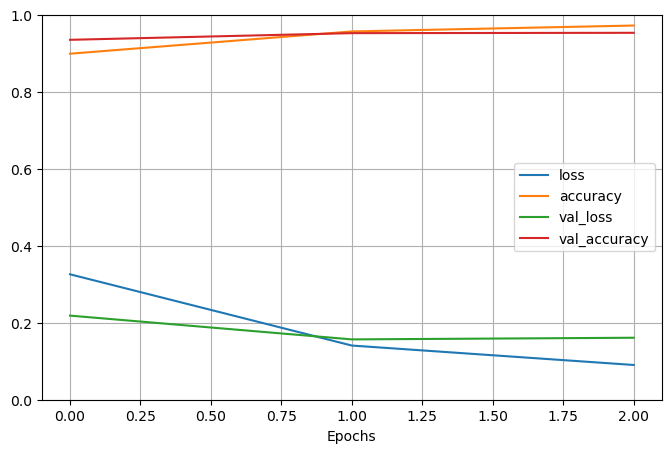

Best Accuracy: 0.953000009059906 At Index: 2
Epoch 1/60
750/750 [==============================] - 2s 2ms/step - loss: 0.3577 - accuracy: 0.8899 - val_loss: 0.2599 - val_accuracy: 0.9208
Epoch 2/60
750/750 [==============================] - 1s 1ms/step - loss: 0.1958 - accuracy: 0.9415 - val_loss: 0.2283 - val_accuracy: 0.9337
Epoch 3/60
750/750 [==============================] - 1s 1ms/step - loss: 0.1627 - accuracy: 0.9519 - val_loss: 0.2340 - val_accuracy: 0.9413


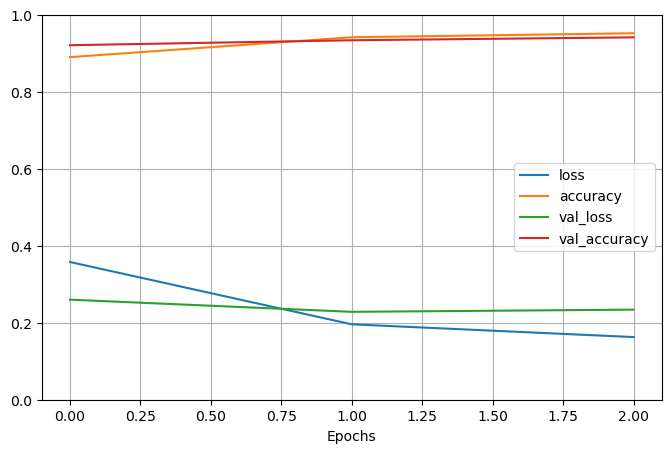

Best Accuracy: 0.9412500262260437 At Index: 2
Epoch 1/60
750/750 [==============================] - 2s 2ms/step - loss: 0.3932 - accuracy: 0.8810 - val_loss: 0.3289 - val_accuracy: 0.9008
Epoch 2/60
750/750 [==============================] - 1s 1ms/step - loss: 0.2393 - accuracy: 0.9310 - val_loss: 0.2726 - val_accuracy: 0.9277
Epoch 3/60
750/750 [==============================] - 1s 1ms/step - loss: 0.1974 - accuracy: 0.9441 - val_loss: 0.2659 - val_accuracy: 0.9304
Epoch 4/60
750/750 [==============================] - 1s 1ms/step - loss: 0.1768 - accuracy: 0.9510 - val_loss: 0.2650 - val_accuracy: 0.9357
Epoch 5/60
750/750 [==============================] - 1s 1ms/step - loss: 0.1536 - accuracy: 0.9567 - val_loss: 0.2801 - val_accuracy: 0.9332


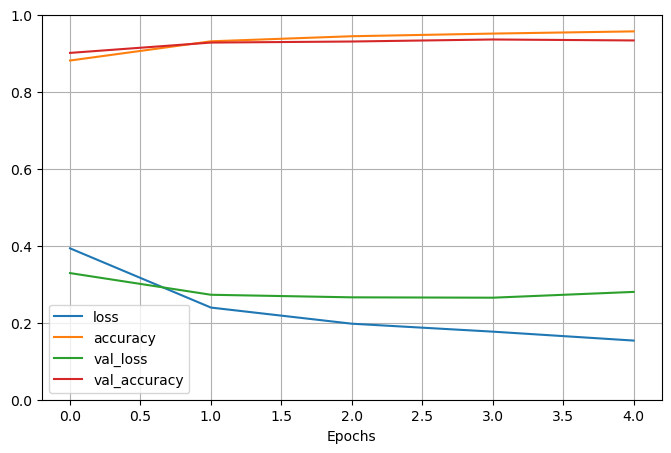

Best Accuracy: 0.9356666803359985 At Index: 3
Epoch 1/60
750/750 [==============================] - 2s 2ms/step - loss: 0.4457 - accuracy: 0.8680 - val_loss: 0.4012 - val_accuracy: 0.8867
Epoch 2/60
750/750 [==============================] - 1s 1ms/step - loss: 0.2888 - accuracy: 0.9181 - val_loss: 0.2979 - val_accuracy: 0.9197
Epoch 3/60
750/750 [==============================] - 1s 1ms/step - loss: 0.2512 - accuracy: 0.9301 - val_loss: 0.2763 - val_accuracy: 0.9274
Epoch 4/60
750/750 [==============================] - 1s 1ms/step - loss: 0.2243 - accuracy: 0.9380 - val_loss: 0.3145 - val_accuracy: 0.9163


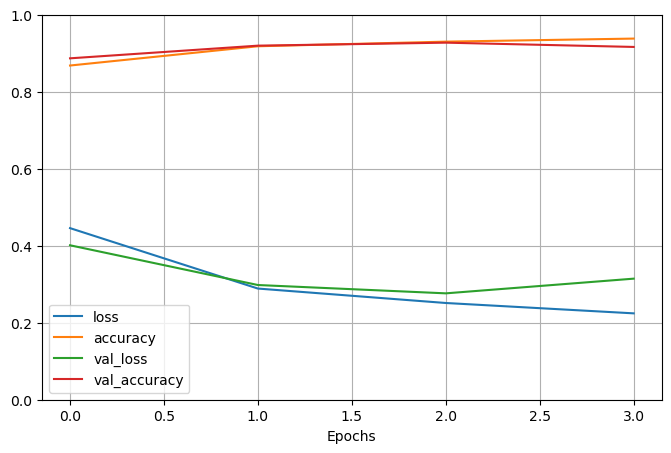

Best Accuracy: 0.9274166822433472 At Index: 2


In [19]:
learning_rates = [0.0005, 0.001, 0.002, 0.005, 0.007, 0.01]
best_accuracies = []
epochs = []
for i in learning_rates:
    history = MLP(2, "relu", 400, "Adam", i, miniBatch=64)
    accuracies = history.history['val_accuracy']
    best_acc = max(accuracies)
    best_accuracies.append(best_acc)
    idx = accuracies.index(best_acc)
    epochs.append((idx+1))

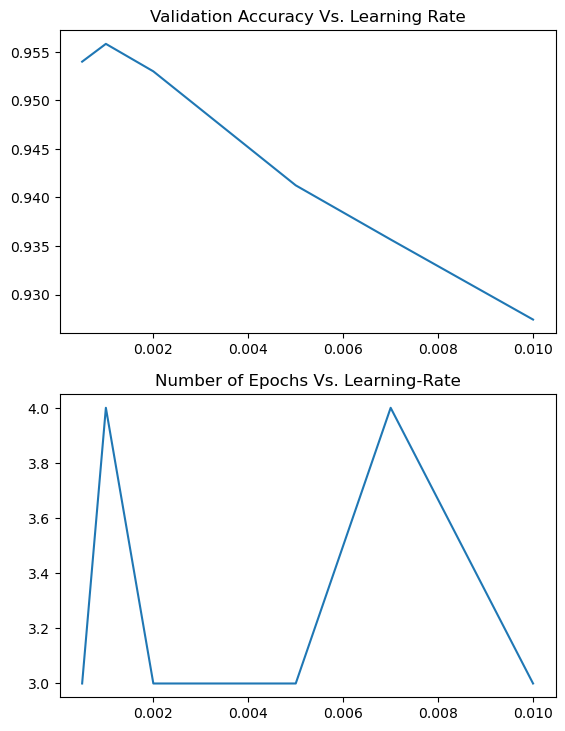

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(top=1.5)
ax1.set_title("Validation Accuracy Vs. Learning Rate")
ax2.set_title("Number of Epochs Vs. Learning-Rate")
ax1.plot(learning_rates, best_accuracies)
ax2.plot(learning_rates, epochs)

The optimal learning rate turned out to be 0.001, which is the default value for the Adam optimizer.

# Testing the Model Using the Testing Data

With our parameters figured out, let us now assembled the model with the parameters we found to work best, and use it to predict our testing data, to give a final performance score.

Epoch 1/60
750/750 [==============================] - 2s 2ms/step - loss: 0.3504 - accuracy: 0.8929 - val_loss: 0.2193 - val_accuracy: 0.9325
Epoch 2/60
750/750 [==============================] - 1s 2ms/step - loss: 0.1429 - accuracy: 0.9560 - val_loss: 0.1720 - val_accuracy: 0.9473
Epoch 3/60
750/750 [==============================] - 1s 1ms/step - loss: 0.0829 - accuracy: 0.9746 - val_loss: 0.1404 - val_accuracy: 0.9581
Epoch 4/60
750/750 [==============================] - 1s 1ms/step - loss: 0.0549 - accuracy: 0.9837 - val_loss: 0.1753 - val_accuracy: 0.9504


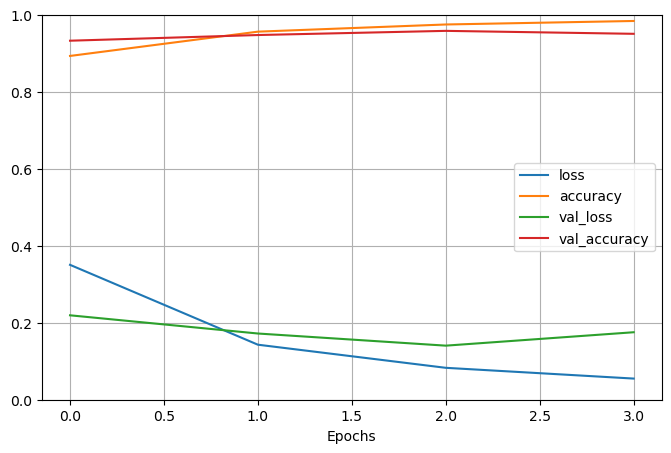

Best Accuracy: 0.9580833315849304 At Index: 2


In [21]:
history = MLP(2, "relu", 400, "Adam", 0.001, miniBatch=64)

In [33]:
ds_test, train_info = tfds.load("kmnist", split="test", with_info=True, as_supervised=True, batch_size=-1)
X_test = ds_test[0].numpy()
y_test = ds_test[1].numpy()
X_test = X_test[:, :, :, 0]
X_test = X_test[:] / 255.0

In [36]:
model = history.model
model.evaluate(X_test, y_test)


313/313 [==============================] - 0s 890us/step - loss: 0.4105 - accuracy: 0.8961


[0.4104844629764557, 0.8960999846458435]

Approximately 90% accuracy, not bad!